# Signal 1, also known as Day1 signal

The starting point for the post result project

**Index**
- Packages
- Data acquisition
- Utility functions
    - General helper
    - Signal functions
    - Performance utility functions
- Average return trajectory for short
- Account curve for long
    - Variations including time periods, entry point, question around earning, stop loss, moving average, high, size, country, sector, PE, market correlation
    - Possible combinations of signal building blocks
    - US vs Europe
- Average return trajectory for short
- Account curve for short
    - Same logic
- Build a portfolio
- Logistic regression    


## 1 - Packages import

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from scipy import stats
from textwrap import wrap
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


%matplotlib inline

## 2 - Data acquisition

Store the data in excel and extract them from following functions
- Fundamental data including revision, market cap, volume, PE, sector
- Absolute price, relative price, absolute return, relative return

In [2]:
#initial cleaning function
def clean_sheet(dataframe):
    adj=dataframe.dropna(axis=1,how='all')
    adj=dataframe.set_index(adj.columns[0]) #use stock tickers as the index
    return adj

In [3]:
# add a function to grab country
def get_country(ticker):
    if type(ticker)==str:
        return ticker[-2:]
    else:
        return None

In [4]:
#pull the data from excel, form a dictionary of tab names and dataframes
tabs_to_grab=['Quarter','Date','Revision','Market cap','Volume','PE','PE premium','Property']

# Europe
data_dict_Europe={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe 2007-2017.xlsx',sheet_name=s))
    data_dict_Europe[s]=df
    
# select the right universe for Europe
universe_evaluate_Europe=(data_dict_Europe["Market cap"]>500)&(data_dict_Europe["Volume"]>5)
data_dict_Europe["Revision"]=data_dict_Europe["Revision"][universe_evaluate_Europe]
data_dict_Europe["Market cap"]=data_dict_Europe["Market cap"][data_dict_Europe["Market cap"]>500]

In [5]:
# US
data_dict_US={}

for s in tabs_to_grab:
    df=clean_sheet(pd.read_excel(r'C:\Users\Eric.Li\Documents\Post result data\US 2007-2017.xlsx',sheet_name=s))
    df["country"]=df.apply(lambda x:get_country(x.name),axis=1)
    df=df[df["country"]!='CN']
    del df['country']
    data_dict_US[s]=df

# select the right universe for US
universe_evaluate_US=(data_dict_US["Market cap"]>1000)&(data_dict_US["Volume"]>5)
data_dict_US["Revision"]=data_dict_US["Revision"][universe_evaluate_US]
data_dict_US["Market cap"]=data_dict_US["Market cap"][data_dict_US["Market cap"]>1000]

In [6]:
# global
data_dict_global={}

for s in tabs_to_grab:
    df=pd.concat([data_dict_Europe[s],data_dict_US[s]],axis=0)
    data_dict_global[s]=df

In [7]:
# get the price dataframe for certain years; form the price and return datetime from the data from all the years 
def price_from_excel(path, start_year,end_year):
    
    year_range=range(start_year,end_year+1)

    price_list=[]

    for year in year_range:
        price_year=clean_sheet(pd.read_excel(path,sheet_name=str(year))).dropna(how='all',axis=0)
        price_list.append(price_year)

    price=pd.concat(price_list,axis=1).dropna(axis=1,how='all').dropna(axis=0,how='all')

    # transform the datetime to the common timestamp format
    price_column=[i.strftime("%d/%b/%Y") for i in price.columns.tolist() if type(i)!=str]
    price.columns=price_column
    
    return price

In [8]:
# get price_df
price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe price 2007-2017.xlsx',2007,2017)
price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US price 2007-2017.xlsx',2007,2017)

In [9]:
# open price
open_price_Europe=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\Europe open price 2007-2017.xlsx',2007,2017)
open_price_US=price_from_excel(r'C:\Users\Eric.Li\Documents\Post result data\US open price 2007-2017.xlsx',2007,2017)

In [108]:
def get_return(price_df,open_price,benchmark,sector_df):
    rel_price=price_df/price_df.loc[benchmark]
    rel_price=rel_price.dropna(how='all',axis=0)
    abs_return=price_df.diff(1,axis=1)/price_df.shift(1,axis=1)
    abs_return=abs_return.dropna(how='all',axis=0)
    rel_return=abs_return - abs_return.loc[benchmark]
    rel_return=rel_return.dropna(how='all',axis=0)
    rel_return_sector=abs_return.dropna(axis=0,how='all').apply(lambda x: x-abs_return.loc[sector_df.loc[x.name].Index] if x.name[-2:]!='CN' and x.name[-3:-2]==' ' and not pd.isnull(sector_df.loc[x.name].Index) else x,axis=1)
    abs_open_ret=open_price/price_df.shift(1,axis=1)-1
    rel_open_ret=abs_open_ret-abs_open_ret.loc[benchmark]
    return rel_price,abs_open_ret,rel_open_ret,abs_return,rel_return,rel_return_sector

In [109]:
# get return dfs
rel_price_Europe,abs_open_ret_Europe,rel_open_ret_Europe,abs_return_Europe,rel_return_Europe,rel_return_sector_Europe=get_return(price_Europe,open_price_Europe,'SXXP Index',data_dict_Europe["Property"])
rel_price_US,abs_open_ret_US,rel_open_ret_US,abs_return_US,rel_return_US,rel_return_sector_US=get_return(price_US,open_price_US,'SPX Index',data_dict_US["Property"])

In [165]:
# Data check
(abs_open_ret_Europe.mean(axis=1).sort_values()[:10],abs_open_ret_Europe.mean(axis=1).sort_values()[-10:])
(abs_open_ret_US.mean(axis=1).dropna().sort_values()[:10],abs_open_ret_US.mean(axis=1).dropna().sort_values()[-10:])
#(abs_return_Europe.min(axis=1).sort_values()[:10],abs_return_Europe.max(axis=1).sort_values()[-10:])
#(abs_return_US.min(axis=1).sort_values()[:10],abs_return_US.max(axis=1).sort_values()[-10:])

(PNR US    -0.328522
 BW US     -0.284596
 EEQ US    -0.036012
 XL US     -0.034253
 WPM CN    -0.023893
 CRC US    -0.009046
 BGRP US   -0.005960
 INFI US   -0.004323
 WTE CN    -0.002829
 CNGO US   -0.002580
 dtype: float64, VNCE US           0.017814
 DNLI US           0.020115
 FUEL US           0.021997
 ONDK US           0.030101
 TCS US            0.032497
 CEIX US           0.036737
 X US              0.048025
 LFIN US           0.127004
 GSRPEMEL Index    0.196663
 GSRPEMUL Index    0.304419
 dtype: float64)

In [142]:
abs_open_ret_US.loc["DNLI US"].dropna().sort_values()

12/Dec/2017   -0.000953
18/Dec/2017    0.000525
19/Dec/2017    0.000534
20/Dec/2017    0.001094
27/Dec/2017    0.001294
13/Dec/2017    0.002976
14/Dec/2017    0.002994
11/Dec/2017    0.003263
28/Dec/2017    0.005678
29/Dec/2017    0.007314
26/Dec/2017    0.007605
22/Dec/2017    0.009119
15/Dec/2017    0.013691
21/Dec/2017    0.017514
25/Dec/2017    0.051965
08/Dec/2017    0.197222
Name: DNLI US, dtype: float64

## 3 - Utility functions

Collect all the utility functions in one place


### 3.1 General helper functions
- Calculation incl. nmove, vol, sector, market cap, EAR
- AUTOR, MA

In [12]:
# utility function to obtain the gap
def gap_calc(ticker,date,open_ret,return_df,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    open_ret_series=open_ret.loc[ticker].dropna()
    return_series=return_df.loc[ticker].dropna()
    date_series=open_ret_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=open_ret_series.iloc[day0]
        nmove=ret/vol     
        return nmove
    else:
        return None

In [13]:
# obtain the announcement return dataframe from price return and date dataframe
def gap_df(date_df,open_ret,return_df,vol_lookback):
    gap_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            gap_series=date_row.apply(lambda x: gap_calc(ticker,x,open_ret,return_df,vol_lookback))
            gap_list.append(gap_series)
        else:
            pass
    gap_df=pd.concat(gap_list,axis=1).T
    return gap_df

In [14]:
# utility function to obtain announcement return (as a multiplier of vol) as a result of day 0 and return dataframe
def EAR_calc(ticker,date,return_df,EAR_period,vol_lookback):
    if type(date)==pd._libs.tslib.NaTType:
        return None
    elif type(date)==pd._libs.tslib.Timestamp:
        date=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        date=date
    return_series=return_df.loc[ticker].dropna()
    date_series=return_series.index.tolist()
    if date in date_series:
        day0=date_series.index(date)
        post_series=return_series.iloc[day0:]
        pre_series=return_series.iloc[:day0]
        vol= return_series.iloc[day0-min(len(pre_series),vol_lookback+1):day0].std()
        ret=(return_series.iloc[day0:day0+EAR_period]+1).prod()-1
        nmove=ret/vol
        return nmove
    else:
        return None

In [15]:
# obtain the announcement return dataframe from price return and date dataframe
def EAR_df(date_df,return_df,EAR_period,vol_lookback):
    EAR_list=[]
    for ticker, date_row in date_df.iterrows():
        if type(ticker)==str: #deal with None
            ret_series=date_row.apply(lambda x: EAR_calc(ticker,x,return_df,EAR_period,vol_lookback))
            EAR_list.append(ret_series)
        else:
            pass
    EAR_df=pd.concat(EAR_list,axis=1).T
    return EAR_df

In [145]:
#test_gap_US=gap_df(data_dict_US["Date"],rel_open_ret_US,rel_return_US,30)
test_gap_Europe=gap_df(data_dict_Europe["Date"],rel_open_ret_Europe,rel_return_Europe,30)

In [146]:
(test_gap_Europe.mean(axis=1).dropna().sort_values()[:10],test_gap_Europe.mean(axis=1).dropna().sort_values()[-10:])

(E2V LN        -5.039356
 CXP NA        -4.616017
 BCHN SW       -4.252638
 SPIE FP       -3.861189
 2989577Q LN   -3.284250
 BFD LN        -3.194699
 MONY LN       -2.846071
 IBAB BB       -2.819026
 RIA FP        -2.758045
 TCHNR FP      -2.410510
 dtype: float64, PLUS LN     2.754154
 ASRNL NA    2.772251
 PAYS LN     2.778394
 CVSG LN     2.838646
 FNAC FP     3.087055
 AHSL SS     3.093984
 JD/ LN      3.179656
 DBG FP      3.243046
 KIE LN      3.940397
 MRO LN      3.940792
 dtype: float64)

In [167]:
test_gap_US.loc["SNTS US"].dropna().sort_values()

Unnamed: 2     3.9415
Unnamed: 3     5.6546
Unnamed: 4    8.81881
Unnamed: 1      18.56
Name: SNTS US, dtype: object

In [125]:
(test_gap_US.mean(axis=1).dropna().sort_values()[:10],test_gap_US.mean(axis=1).dropna().sort_values()[-10:])

(PNR US        -32.053952
 BW US         -17.375298
 SNAP US        -5.929923
 CEMJQ US       -5.395930
 UA US          -4.915637
 ATKR US        -4.593375
 DNDNQ US       -4.252989
 1608358D US    -4.014242
 TTI US         -3.927230
 LAUR US        -3.694802
 dtype: float64, ICUI US    5.067561
 NSIT US    5.331278
 LHCG US    5.771473
 MKTG US    5.827145
 STMP US    5.959504
 AIMC US    6.640267
 ZOLL US    7.120140
 MPG US     8.587492
 VRGY US    8.849938
 SNTS US    9.243727
 dtype: float64)

In [16]:
## sector mapping and unique sector list, add the sector column to the signal
def sector_mapping(ticker,mapping_df):
    mapping=mapping_df.dropna()
    if ticker in mapping.index:
        sector=mapping[ticker]
    else:
        sector=None
    return sector

In [17]:
## function to grab volume
def get_volume(ticker,date,volume_df,date_df):
    date_series=date_df.loc[ticker]
    volume_series=volume_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        volume=volume_series.iloc[location]
        return volume
    except ValueError:
        return None

In [18]:
## function to grab market cap
def get_market_cap(ticker,date,market_cap_df,date_df):
    date_series=date_df.loc[ticker]
    size_series=market_cap_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        size=size_series.iloc[location]
        return size
    except ValueError:
        return None

In [19]:
## function to grab PE
def get_PE(ticker,date,PE_df,date_df):
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None

In [20]:
## function to grad nmove post result
def get_post_nmove(ticker,date,return_df,holding,entry):
    return_series=return_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date.strftime("%d/%b/%Y")
    elif type(date)==str:
        timestamp=date
    else:
        return None   
    try:
        location=return_series.index.tolist().index(timestamp)
        entry_date=return_series.index.tolist()[location+entry]
        nmove=EAR_calc(ticker,entry_date,return_df,holding,30)
        return nmove
    except ValueError:
        return None

In [21]:
## function to grab PE
def get_PE(ticker,date,PE_df,date_df):
    date_series=date_df.loc[ticker]
    PE_series=PE_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE=PE_series.iloc[location]
        return PE
    except ValueError:
        return None

In [22]:
## function to grab PE premium
def get_PE_premium(ticker,date,PE_premium_df,date_df):
    date_series=date_df.loc[ticker]
    PE_premium_series=PE_premium_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        PE_premium=PE_premium_series.iloc[location]
        return PE_premium
    except ValueError:
        return None

In [23]:
## function to grab earning revision
def get_revision(ticker,date,revision_df,date_df):
    date_series=date_df.loc[ticker]
    revision_series=revision_df.loc[ticker]
    if type(date)==pd._libs.tslib.Timestamp:
        timestamp=date
    elif type(date)==str:
        timestamp=pd.Timestamp(datetime.strptime(date,"%d/%b/%Y").year,
                               datetime.strptime(date,"%d/%b/%Y").month,
                               datetime.strptime(date,"%d/%b/%Y").day)
    else:
        return None
    try:
        location=date_series.tolist().index(timestamp)
        revision=revision_series.iloc[location]
        return revision
    except ValueError:
        return None

In [24]:
# AUTOR score and slope
def AUTOR(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        date=date
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]

        regr=linear_model.LinearRegression()
        x_train=np.asarray([x+1 for x in range(min(look_back, pos))]).reshape(-1,1)
        y_train=target_series.values.reshape(-1,1)
        regr.fit(x_train,y_train)  
        slope=regr.coef_
        error=y_train-regr.predict(x_train)
        std_err=np.std(error)
        score=error[-1]/std_err
        return score[0], slope[0][0]
    except ValueError:
        return (None,None)

In [25]:
# MA score 
def MA(ticker,date,look_back,price_df,rel_index):
    if type(date)==pd._libs.tslib.Timestamp:
        date=datetime.strptime(date,"%d/%b/%Y")
    else:
        pass
    
    if rel_index==None:
        price_series=price_df.loc[ticker]
    else:
        price_series=price_df.loc[ticker]/price_df.loc[rel_index]
        
    try:
        pos=price_series.index.tolist().index(date)
        MA=price_series.rolling(look_back).mean()

        target_MA=MA[pos-min(look_back, pos)+1:pos+1]
        target_series=price_series[pos-min(look_back, pos)+1:pos+1]
        if (len(target_MA.dropna())==0)|(len(target_series.dropna())==0):
            return (None,None)
        else:
            MA_score=(target_series.iloc[-1]/target_MA.iloc[-1]-1)/(target_series.diff(1)/target_series.shift(1)).std()
            slope=(target_MA.iloc[-1]-target_MA.iloc[0])/min(look_back, pos+1)
            return MA_score,slope 
    except ValueError:
        return (None,None)

### 3.2 - Signal 1 functions
- Signal 1 by day and date
- Account curve formation
- Signal filter functions

In [26]:
#signal formation (number 1) and use the date as the base dataframe
def signal1_formation(date_df,return_for_signal,EAR_period,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high):
    EAR_return=EAR_df(date_df,return_for_signal,EAR_period,30).fillna(0.0).reindex(revision_df.index.tolist())
    gap=gap_df(date_df, open_ret, return_for_signal, 30).fillna(0.0).reindex(revision_df.index.tolist())
    signal1_evaluate=(EAR_return>EAR_low)&(EAR_return<EAR_high)&(gap>gap_low)&(gap<gap_high) & (revision_df>revision_low)& (revision_df<revision_high)
    signal1=date_df[signal1_evaluate]
    signal1_next=date_df.shift(1,axis=1)[signal1_evaluate]
    return signal1,signal1_next

In [27]:
#Stack signals into a list of tuples (stocks, dates,next earnign dates, next signal dates), convert dates into a common format of datetime
def signal1_stacking(signal1,signal1_next):
    signal1_list=[]
    for ticker, row in signal1.iterrows():
        adj_row=row.dropna()
        if len(adj_row)!=0:
            for idx in range(len(row)):
                date=row.iloc[idx]
                date_next=signal1_next.loc[ticker].iloc[idx]
                if type(date)==pd._libs.tslib.Timestamp:
                    adj_date=date.strftime("%d/%b/%Y") #transform the datetime into a common format
                    loc_date=adj_row.tolist().index(date)
                    if (loc_date>0)&(len(adj_row)>0):
                        next_signal=adj_row.iloc[loc_date-1].strftime("%d/%b/%Y")
                        if type(date_next)==pd._libs.tslib.Timestamp:
                            adj_next_date=date_next.strftime("%d/%b/%Y") 
                        else:
                            adj_next_date=None
                    elif type(date_next)==pd._libs.tslib.Timestamp:
                        next_signal=None
                        adj_next_date=date_next.strftime("%d/%b/%Y") 
                    else:
                        next_signal=None
                        adj_next_date=None                
                    signal1_list.append((row.name,adj_date,adj_next_date,next_signal))
                else:
                    pass
        else:
            pass
    return signal1_list

In [28]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#; replace datetime with number of days post announcement to make it more comparable 
def signal1_dict_day(signal1_list,return_df,holding,earning,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]       
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if earning is True:
                    period=holding
                elif (type(s[2])==pd._libs.tslib.NaTType)|(s[2] is None):
                    period=holding
                else:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna()
                target_series.index=range(entry,len(target_series)+entry) #replace datetime with number of days post announcement
                target_series.name=(s[0],s[1])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [29]:
# obtain the dataframe of return time series for the signal stocks, take the signal_return_dict function
def signal1_df_day(signal1,signal1_next,return_df,holding,earning,entry):
    return_series_list=[]
    return_dict=signal1_dict_day(signal1_stacking(signal1,signal1_next),return_df,holding,earning,entry)
    for index,key in return_dict.items():
        return_series_list.append(key)
    try:
        signal1_df=pd.concat(return_series_list,axis=1)
        return signal1_df
    except ValueError:
        return None

In [30]:
# create a dictionary to have signal information (tuple) as keys and return data time series as values to make it easier to check
#;use actual dates rather than number of days post announcement
def signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry):#if we hold them through next earning
    signal1_dict={}
    for s in signal1_list:
        return_series=return_df.loc[s[0]]
        if (s[1] in return_series.index):
            if not np.isnan(return_series.loc[s[1]]): 
                day0=return_series.index.tolist().index(s[1]) #index of day 0
                if s[2] is None:
                    period=holding
                elif earning is False:
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[2],"%d/%b/%Y"))-entry)
                elif (signal is False) & (s[3] is not None):
                    period=min(holding,np.busday_count(datetime.strptime(s[1],"%d/%b/%Y"),datetime.strptime(s[3],"%d/%b/%Y"))-entry)
                else:
                    period=holding
                target_series=return_series.iloc[day0+entry:day0+min(period+entry, len(return_series[day0:]))].dropna() # different from return_dict with number of dates post announcement
                target_series.name=(s[0])
                signal1_dict[s]=target_series
            else:
                pass
        else:
            pass          
    return signal1_dict

In [31]:
## signal df function adjusted to the actual dates
def signal1_df_date(date_df,return_for_signal,return_df,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high,holding,earning,signal,entry):
    signal1,signal1_next=signal1_formation(date_df,return_for_signal,entry,EAR_low,EAR_high,revision_df,revision_low,revision_high,open_ret,gap_low,gap_high)
    signal1_list=signal1_stacking(signal1,signal1_next)
    signal1_dict=signal1_dict_date(signal1_list,return_df,holding,earning,signal,entry)
    return_list=[]
    for i,v in signal1_dict.items():
        return_list.append(v)
    my_df=pd.concat(return_list,axis=1)
    my_df.columns=list(signal1_dict.keys())
    my_df.index=[datetime.strptime(x,"%d/%b/%Y") for x in my_df.index.tolist()]
    signal1_df=my_df.sort_index()
    signal1_df=signal1_df.dropna(axis=1,how='all')
    return signal1_df

In [406]:
# create dataframe tracking the pnl accumulation, add liquidity constraint
def signal1_account(signal_df_date,average_gross,capital,volume_df,date_df,liquidity_constraint):
    average_number=signal_df_date.count(axis=1).mean()
    avg_size=average_gross/100/average_number
    size_row=signal_df_date.apply(lambda x: min(avg_size,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count=signal_df_date.copy()
    count[(count>=0)|(count<0)]=1.0
    avg_holding=count.sum(axis=0).mean()
    gross=(count*size_row).sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(((signal_df_date+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=(((signal_df_date+1).cumprod()-1)*size_row).ffill().iloc[-1].dropna()
    stock_return=((signal_df_date+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,avg_size,gross,ind_return,turnover,avg_holding,stock_return

In [33]:
def signal1_account_combine(long_df,short_df,long_gross,short_gross,capital,volume_df,date_df,liquidity_constraint,index_df,net_level):
    long_number=long_df.count(axis=1).mean()
    avg_size_long=long_gross/100/long_number
    size_row_long=long_df.apply(lambda x: min(avg_size_long,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
    count_long=long_df.copy()    
    count_long[(count_long>=0)|(count_long<0)]=1.0
    account_long=(((long_df+1).cumprod()-1)*size_row_long).ffill().sum(axis=1)

    if short_df is not None:
        short_number=short_df.count(axis=1).mean()
        avg_size_short=short_gross/100/short_number
        avg_size=(long_gross+short_gross)/100/(long_number+short_number)
        size_row_short=-short_df.apply(lambda x: min(avg_size_short,get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital),axis=0)
        size_row=size_row_long.append(size_row_short)
        count_short=short_df.copy()
        count_short[(count_short>=0)|(count_short<0)]=1.0
        count=pd.concat([count_long,count_short],axis=1)
        account_short=(((short_df+1).cumprod()-1)*size_row_short).ffill().sum(axis=1)
        account_alpha=pd.concat([account_long,account_short],axis=1).sum(axis=1)
        combined_df=pd.concat([long_df,-short_df],axis=1)
        ind_return=pd.concat([((long_df+1).cumprod()-1)*size_row_long,((short_df+1).cumprod()-1)*size_row_short],axis=1).ffill().iloc[-1].dropna()
    else:
        avg_size=avg_size_long
        size_row=size_row_long
        count=count_long
        account_alpha=account_long
        combined_df=long_df
        ind_return=(((long_df+1).cumprod()-1)*size_row_long).ffill().iloc[-1].dropna()
        
    avg_holding=count.sum(axis=0).mean()
    alpha_net=(count*size_row).sum(axis=1)

    if index_df is not None:
        size_index=net_level/100-alpha_net
        net=alpha_net+size_index
        account_index=(index_df*size_index).cumsum()
        account_curve=pd.concat([account_alpha,account_index],axis=1).sum(axis=1)
        gross=np.abs(pd.concat([count*size_row,size_index],axis=1)).sum(axis=1)
        gross=gross[gross!=0]
        turnover=(np.abs(pd.concat([count*size_row,size_index],axis=1).fillna(0.0).diff(1)).sum().sum())/(count.shape[0]/260)
    else:
        net=alpha_net
        gross=np.abs(count*size_row).sum(axis=1)
        gross=gross[gross!=0]
        account_curve=account_alpha
        
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    
    return account_curve,avg_size,gross,ind_return,turnover,avg_holding,net   

In [34]:
## utility function to get the vol from a column of signal_df
def signal1_vol(signal_column,return_df,vol_lookback):
    signal_tuple=signal_column.name
    signal_series=return_df.loc[signal_tuple[0]]
    location=signal_series.index.tolist().index(signal_tuple[1])
    vol_range=min(vol_lookback,len(signal_series[:location]))
    signal_vol=signal_series[location-vol_range-1:location].std()
    return signal_vol

In [407]:
# signal_df post stop loss filter 
def signal1_filter_stop(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop

In [36]:
# signal_df post stop loss drawdown filter 
def signal1_filter_dd(signal_df,dd_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    acct=(1+signal_df).cumprod()-1
    signal_dd=(acct.cummax(axis=0)-acct).expanding(min_periods=1).max()/vol_row
    signal_filter_dd=signal_df[-(signal_dd.shift(1,axis=0)>dd_level)]
    return signal_filter_dd

In [37]:
## filter signal_df with moving average
def signal1_filter_MA_above(signal_df,price_df,MA_lookback):
    MA=(price_df.rolling(MA_lookback,axis=1).mean()<price_df)|(price_df.shift(1).rolling(MA_lookback,axis=1).mean()<price_df.shift(1))
    MA_evaluate=signal_df.apply(lambda x: MA.loc[x.name[0]].loc[x.name[1]])
    signal_filter_MA=signal_df.loc[:,MA_evaluate]
    return signal_filter_MA

In [38]:
## filter signal_df with abs/rel high
def signal1_filter_high(signal_df,price_df,rolling_window):
    high_df=price_df.rolling(window=rolling_window,axis=1).max()==price_df
    high_evaluate=signal_df.apply(lambda x: (high_df.loc[x.name[0]].loc[x.name[1]]) or
                                  high_df.loc[x.name[0]].iloc[high_df.loc[x.name[0]].index.tolist().index(x.name[1])+1]) # either day 1 or day 2
    signal_filter_high=signal_df.loc[:,high_evaluate]
    return signal_filter_high

In [39]:
## filter signal_df with level of gap
def signal1_filter_gap(signal_df,open_ret,return_df,gap_low,gap_high,vol_lookback):
    gap_row=signal_df.apply(lambda column:gap_calc(column.name[0],column.name[1],open_ret,return_df,vol_lookback))
    gap_evaluate= (gap_row>gap_low)&(gap_row<gap_high)
    signal_filter_gap=signal_df.loc[:,gap_evaluate]
    return signal_filter_gap

In [40]:
# Following signal date series for a signal series
def signal1_follow(signal1,date_df,length):
    signal1_follow=pd.DataFrame()
    for ticker,row in signal1.iterrows():
        adj_row=row.dropna()
        if (len(adj_row)==0)|(type(adj_row.name)==float):
            pass
        else:
            date_series=date_df.loc[adj_row.name]
            for val in adj_row:
                signal1_follow_list=[val]
                pos=date_series.tolist().index(val)
                for i in range(length):
                    next_result=date_series.shift(i+1).iloc[pos]
                    if type(next_result)==pd._libs.tslib.Timestamp:  
                        signal1_follow_list+=[next_result,]
                    else:
                        signal1_follow_list+=[None,]
            signal1_follow[adj_row.name,val.strftime("%d/%b/%Y")]=signal1_follow_list
            signal1_follow=signal1_follow.reindex(['Quarter+'+str(x) for x in range(length+1)])
    return signal1_follow

In [41]:
# Transform the signal1_follow dates to EAR
def signal1_follow_EAR(signal1_follow,return_df,EAR_period,vol_lookback):
    signal1_follow_EAR=signal1_follow.copy()
    for col in signal1_follow:
        signal1_follow_EAR[col]=[EAR_calc(col[0],x,return_df, EAR_period, vol_lookback) for x in signal1_follow[col].tolist()]
    signal1_follow_EAR=signal1_follow_EAR.loc[:,-pd.isnull(signal1_follow_EAR.iloc[0])]
    return signal1_follow_EAR       

### 3.3 - Performance utility functions
- Trading analytics by day and date
- Performance chart by day and date

In [42]:
def trading_analytics_day(signal_df_day):
    ind_return=((1+signal_df_day).cumprod()-1).ffill().iloc[-1]
    signal1_count=len(ind_return)
    if signal1_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        return mean_return,signal1_count, hit_rate,payoff_ratio

In [43]:
def perf_chart_day(signal_df_day,xlabel,ylabel,title,figsize,quantile_list):
    quantile_columns=[str(int(i*100))+' percentile' for i in quantile_list]
    cum_return=((1+signal_df_day).cumprod()-1).ffill().mean(axis=1)
    perf_df=((1+signal_df_day).cumprod()-1).ffill().apply(lambda row: row.quantile(quantile_list),axis=1)
    perf_df.columns=quantile_columns
    perf_df["Mean"]=cum_return
    
    ax=perf_df.plot(figsize=figsize)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    vals=ax.get_yticks()
    start=vals[0]
    end=vals[-1]
    ax.set_yticks(np.arange(start,end,0.05))  
    adj_vals=ax.get_yticks()
    ax.set_yticklabels(["{:.0%}".format(x) for x in adj_vals])
    
    mean_return,count,hit, payoff=trading_analytics_day(signal_df_day)
    
    plt.title('mean_return='+str("{:.1%}".format(mean_return)+
              ',count='+str(count)+
              ',hit rate='+str("{:.0%}".format(hit))+
              ',payoff='+str(round(payoff,2))),fontsize=10)
    
    plt.suptitle(title,fontsize=14)
    plt.legend(fontsize=8)
    plt.grid(linestyle='dashed')
    plt.axhline(y=0,color='k')

    plt.show()

In [44]:
def trading_analytics_date(signal_account):
    ind_return=signal_account[3]
    signal_count=len(ind_return)
    account_curve=signal_account[0]
    
    if signal_count==0:
        return None
    else:
        mean_return=ind_return.mean()
        hit_rate=len(ind_return[ind_return>0])/len(ind_return)*1.0
        payoff_ratio=ind_return[ind_return>0].mean()/ind_return[ind_return<0].mean()*-1.0
        
        account_price=account_curve+1
        ann_vol=np.std(account_price.diff()/account_price.shift(1))*(260**0.5)
        ann_ret=np.mean(account_price.diff()/account_price.shift(1))*260
        ann_sharpe=ann_ret/ann_vol
        
        low_date=(np.maximum.accumulate(account_curve)-account_curve).idxmax()
        high_date=account_curve[:low_date].idxmax()
        max_dd=1-(1+account_curve[low_date])/(1+account_curve[high_date])
        
        return signal_count,hit_rate,payoff_ratio,ann_ret,ann_vol,ann_sharpe,max_dd

In [229]:
def plot_account_curve(signal_account,xlabel,title,figsize):
    if len(signal_account)==6:
        account_curve,avg_size,gross,ind_return,turnover,avg_holding=signal_account
    elif len(signal_account)==7:
        account_curve,avg_size,gross,ind_return,turnover,avg_holding,stock_return=signal_account
    
    fig=plt.figure(figsize=figsize)
    ax1=fig.add_subplot(1,1,1)
    ln1=ax1.plot(account_curve,label='signal',color='b')

    val1=ax1.get_yticks()
    start=val1[0]
    end=val1[-1]
    ax1.set_yticks(np.arange(start,end,0.1))  
    adj_val1=ax1.get_yticks()
    ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
    
    ax2=ax1.twinx()
    ln2=ax2.plot(gross,label='gross',color='silver')

    val2=ax2.get_yticks()
    start=val2[0]
    end=val2[-1]
    ax2.set_yticks(np.arange(start,end,0.1))  
    adj_val2=ax2.get_yticks()
    ax2.set_yticklabels(["{:.0%}".format(x) for x in adj_val2])
    
    count,hit,payoff,ret,vol,sharpe,max_dd=trading_analytics_date(signal_account)
    
    plt.title("\n".join(wrap('count='+str(count)+
                             ',avg_size='+str("{:.1%}".format(avg_size))+
                             #',avg_holding='+str(int(avg_holding))+
                             ',avg_return='+str("{:.1%}".format(stock_return.mean()))+
                             ',hit_rate='+str("{:.0%}".format(hit))+
                             ',payoff='+str(round(payoff,1))+
                             ',return='+str("{:.1%}".format(ret))+
                             ',vol='+str("{:.1%}".format(vol))+
                             ',sharpe='+str(round(sharpe,1))+
                             ',turnover='+str(round(turnover,1))+'x'+                             
                             ',max_drawdown='+str("{:.1%}".format(max_dd)))),fontsize=10)
 
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('Return')
    ax2.set_ylabel('Exposure')
    plt.suptitle(title,y=1.05,fontsize=16)
    plt.grid(linestyle='dashed')
    plt.legend(ln1+ln2,[l.get_label() for l in ln1+ln2])
    ax1.axhline(y=0,color='k')

    plt.show()

In [46]:
# plot the account curve for different sectors
def plot_account_curve_by_sector(sector_df,figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    sector_list=list(set(sector_df.dropna().values))
    sector_row=signal_rel_df_date.apply(lambda x: sector_mapping(x.name[0],sector_df),axis=0)
    
    for idx, sector in enumerate(sector_list):
        signal_rel_df_date_sector=signal_rel_df_date.loc[:,sector_row==sector]
                
        ax1=fig.add_subplot(len(sector_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_sector,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(sector))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    


    
    plt.show()

In [47]:
# plot the performance for different sectors
def plot_account_curve_by_country(figsize,fontsize,title,signal_rel_df_date,gross,capital,volume_df,date_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.89)
    country_row=signal_rel_df_date.apply(lambda x: x.name[0][-2:],axis=0)
    country_list=list(set(country_row.dropna().values))      
    
    for idx, country in enumerate(country_list):
        signal_rel_df_date_country=signal_rel_df_date.loc[:,country_row==country]
                
        ax1=fig.add_subplot(len(country_list),2,idx+1)
        account=signal1_account(signal_rel_df_date_country,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title(str(country))
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                   #',hit_rate='+str("{:.0%}".format(hit))+
                                   #',payoff='+str(round(payoff,2))+
                                   #',avg_size='+str("{:.1%}".format(account[1]))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))
                                 #',sharpe='+str(round(sharpe,1))+
                                 #',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
  
    
    plt.show()

In [48]:
# plot the performance for different sizes
def plot_account_curve_by_size(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,size_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    size_row_date=signal1_df_date.apply(lambda x: get_market_cap(x.name[0],x.name[1],size_df,date_df),axis=0)
    quantile_value=size_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_size=signal1_df_date.loc[:,(size_row_date>=quantile_value[idx])&(size_row_date<=quantile_value[idx+1])]                             
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_size,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by market cap "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

In [49]:
# plot the performance for different PE
def plot_account_curve_by_PE(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,PE_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_row_date=signal1_df_date.apply(lambda x: get_PE(x.name[0],x.name[1],PE_df,date_df),axis=0)
    quantile_value=PE_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_row_date>=quantile_value[idx])&(PE_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE "+str(round(quantile_value[idx],1))+" - "+str(round(quantile_value[idx+1],1)))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

In [50]:
# plot the performance for different PE premium
def plot_account_curve_by_PE_premium(quantile_list,figsize,fontsize,title,signal1_df_date,gross,capital,volume_df,date_df,PE_premium_df,liquidity_constraint):    
    fig=plt.figure(figsize=figsize)
    fig.suptitle(title, fontsize=fontsize, y=0.93)
    PE_premium_row_date=signal1_df_date.apply(lambda x: get_PE_premium(x.name[0],x.name[1],PE_premium_df,date_df),axis=0)
    quantile_value=PE_premium_row_date.quantile(quantile_list).values.tolist()
    
    for idx in range(len(quantile_value)-1):
        signal_df_date_PE=signal1_df_date.loc[:,(PE_premium_row_date>=quantile_value[idx])&(PE_premium_row_date<=quantile_value[idx+1])]            
        
        ax1=fig.add_subplot(len(quantile_list)+1,1,idx+1)      
        account=signal1_account(signal_df_date_PE,gross,capital,volume_df,date_df,liquidity_constraint)
        account_curve=account[0]
        ax1.plot(account_curve,color='b')
        ax1.set_title("Account Curve by PE premium "+str("{:.0%}".format(quantile_value[idx]))+" to "+str("{:.0%}".format(quantile_value[idx+1])))
    
        val1=ax1.get_yticks()
        start=val1[0]
        end=val1[-1]
        ax1.set_yticks(np.arange(start,end,0.1))  
        adj_val1=ax1.get_yticks()
        ax1.set_yticklabels(["{:.0%}".format(x) for x in adj_val1])
        
        ax1.grid(linestyle='dashed')
        ax1.axhline(y=0,color='k')
            
        count,hit,payoff,ret,vol,sharpe,dd=trading_analytics_date(account)

        ax1.legend(["\n".join(wrap('count='+str(count)+
                                    ',avg_size='+str("{:.1%}".format(account[1]))+
                                #',hit_rate='+str("{:.0%}".format(hit))+
                                 #',payoff='+str(round(payoff,1))+
                                 ',return='+str("{:.1%}".format(ret))+
                                 ',vol='+str("{:.1%}".format(vol))+
                                 ',sharpe='+str(round(sharpe,1))+
                                 ',turnover='+str(round(account[4],1))+'x'+      
                                 ',drawdown='+str("{:.1%}".format(dd))
                                  ))],fontsize=10)        
    
    
    plt.show()

## 4 - Average return trajectory for long

In [552]:
# obtain the long signals
signal1_Europe,signal1_Europe_next=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,2,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000)
signal1_US,signal1_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,2,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-1000,1000)

In [52]:
# long signal dataframe
signal1_abs_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,abs_return_Europe,120,True,2)
signal1_rel_df_Europe=signal1_df_day(signal1_Europe,signal1_Europe_next,rel_return_Europe,120,True,2)

signal1_abs_df_US=signal1_df_day(signal1_US,signal1_next_US,abs_return_US,120,True,2)
signal1_rel_df_US=signal1_df_day(signal1_US,signal1_next_US,rel_return_US,120,True,2)

In [55]:
# List of signals and cumulative returns
signal1_list_abs=((1+signal1_abs_df_Europe).cumprod(axis=0)-1).iloc[-1]
signal1_list_abs

signal1_list_rel=((1+signal1_rel_df_Europe).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_list_rel.sort_values()

ALT GR    26/Apr/2007   -0.695384
TOM2 NA   24/Oct/2007   -0.582579
BOL SS    08/May/2008   -0.562069
MT NA     14/May/2008   -0.530302
REC NO    18/Jul/2014   -0.518723
BKT SM    19/Jan/2012   -0.515032
MT NA     30/Jul/2008   -0.511840
SDF GR    14/Mar/2013   -0.510868
RHA FP    30/Jul/2008   -0.510557
ALU FP    10/Feb/2012   -0.487421
YAR NO    18/Apr/2008   -0.469862
NRE1V FH  07/May/2008   -0.465005
OTE1V FH  23/Apr/2008   -0.454392
NHY NO    22/Apr/2008   -0.443289
BOL SS    19/Jul/2007   -0.435129
SUB NO    22/Jul/2008   -0.434482
AF FP     18/Feb/2016   -0.428473
AGFB BB   03/May/2007   -0.415944
AIXA GR   01/Mar/2011   -0.413849
REC NO    13/Feb/2015   -0.410456
STERV FH  23/Oct/2008   -0.408561
REC NO    22/Apr/2008   -0.401713
EMG LN    29/May/2008   -0.398658
SUBC NO   31/Jul/2014   -0.392219
SSABA SS  29/Apr/2011   -0.390019
          23/Jul/2014   -0.389436
BOKA NA   21/Aug/2008   -0.381226
APAM NA   07/Feb/2012   -0.380423
PAYS LN   10/Sep/2014   -0.376977
NHY NO    11/F

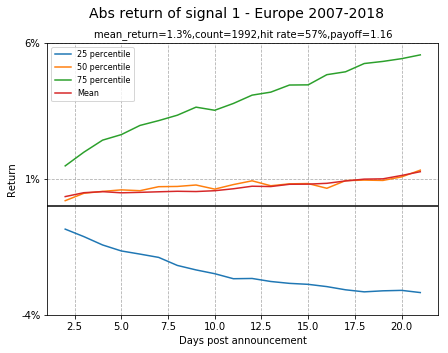

In [58]:
perf_chart_day(signal1_abs_df_Europe.iloc[:20],"Days post announcement",
           "Return","Abs return of signal 1 - Europe 2007-2018",[7,5],
          [0.25,0.5,0.75])

## 5 - Account curve for long

Simulated performance of the portfolio by actual dates
- Basic plot
- By sectors
- By countries
- By size
- By PE
- By PE premium
- By holding period
- By entry point
- Stop loss
- Drawdown
- Moving average
- High price
- **Signal combination**
- Correlation with markets
- Performance for the following results

### 5.1 - Basic plot

In [553]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,60,False,False,1)
signal1_abs_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,abs_open_ret_Europe,-1000,1000,60,False,False,1)

In [174]:
# singal1 dataframe by actual date US
signal1_rel_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-1000,1000,60,False,False,1)
signal1_abs_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,2,1000,data_dict_US['Revision'],0.05,1000,abs_open_ret_US,-1000,1000,60,False,False,1)

In [175]:
# concatnate two dataframes to a global version
signal1_rel_df_date_global=pd.concat([signal1_rel_df_date_Europe,signal1_rel_df_date_US],axis=1)
signal1_abs_df_date_global=pd.concat([signal1_abs_df_date_Europe,signal1_abs_df_date_US],axis=1)

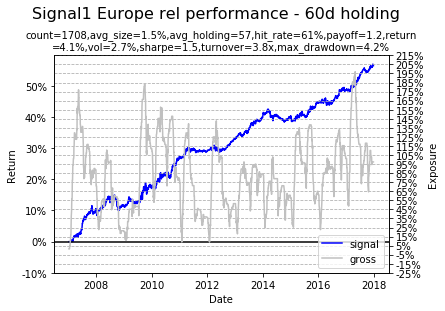

In [176]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe rel performance - 60d holding",[6,4])

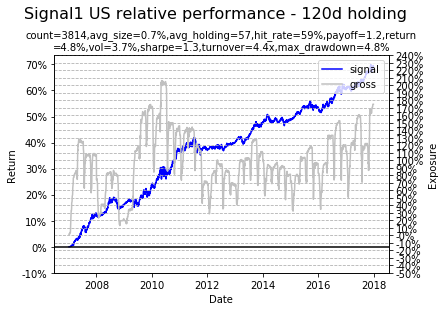

In [161]:
plot_account_curve(signal1_account(signal1_rel_df_date_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US relative performance - 60d holding",[6,4])

### 5.1 - Account curve by sectors

In [357]:
plot_account_curve_by_sector(data_dict_Europe["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",signal1_rel_df_date,
                            50,5,volume,data_dict_Europe["Date"],0.1)

### 5.2 - Account curve by countries

In [356]:
plot_account_curve_by_country((15,70),18,
                            "Performance of signal 1 for Europe 2007-2018",signal1_rel_df_date,
                            50,10,volume,data_dict_Europe["Date"],0.1)

### 5.3 - Account curve by size

In [353]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,18),18,
                            "Account curve of signal 1 by size groups",signal1_rel_df_date,
                            50,30,volume,data_dict_Europe["Date"],market_cap,0.1)

### 5.4 - Account curve by PE

In [871]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict_Europe["Date"],data_dict_Europe["PE"],0.1)

### 5.5 - Account curve by PE premium

In [ ]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",signal1_rel_df_date,
                            50,20,volume,data_dict["Date"],PE_premium,0.1)

### 5.6 - Account curve by different holding periods

In [366]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,30,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 30d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,60,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 60d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,120,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,240,False,False,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                                   "Date","Signal1 account curve - 240d holding",[6,4])

SyntaxError: invalid syntax (<ipython-input-366-e89e33a265a7>, line 1)

### 5.7 - Account curve by entry point

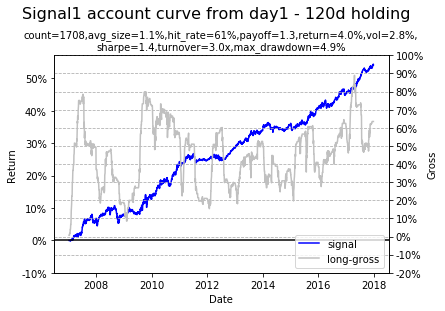

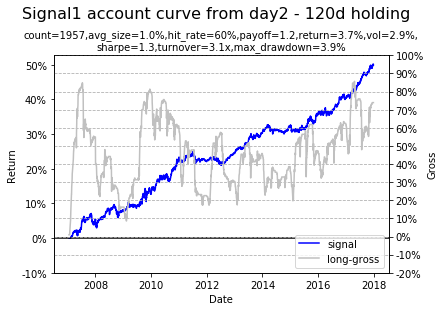

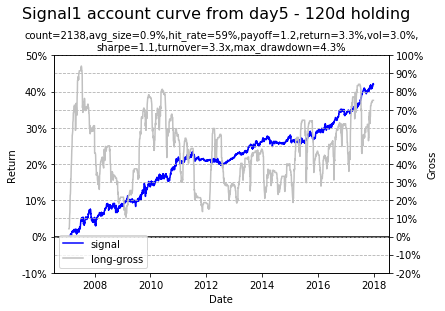

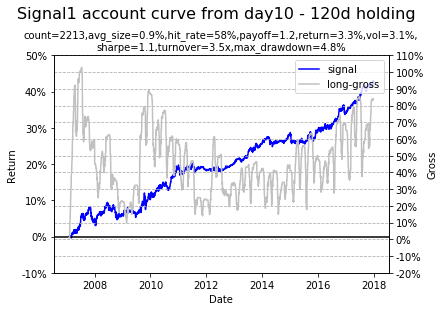

In [653]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,120,False,False,1)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day1 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,120,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,120,False,False,5)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day5 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,100,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,1000,120,False,False,10)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day10 - 120d holding",[6,4])

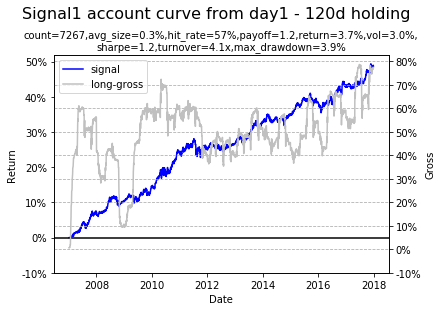

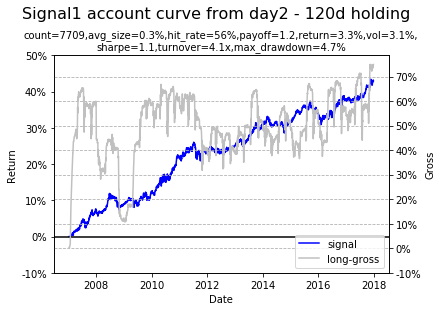

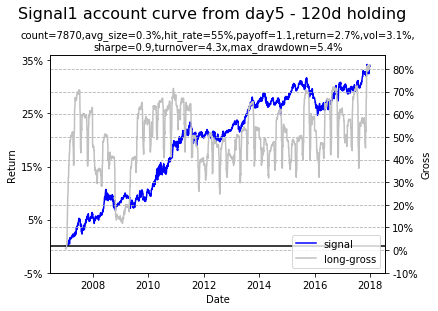

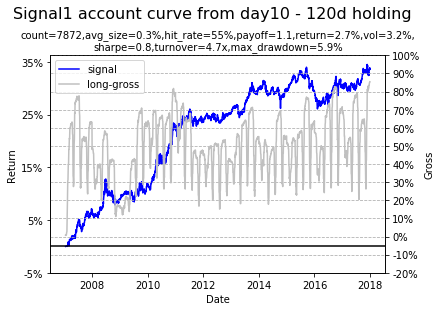

In [654]:
plot_account_curve(signal1_account(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,100,data_dict_US['Revision'],0.02,1000,rel_open_ret_US,-1000,1000,120,False,False,1)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 account curve from day1 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,100,data_dict_US['Revision'],0.02,1000,rel_open_ret_US,-1000,1000,120,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,100,data_dict_US['Revision'],0.02,1000,rel_open_ret_US,-1000,1000,120,False,False,5)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 account curve from day5 - 120d holding",[6,4])

plot_account_curve(signal1_account(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,100,data_dict_US['Revision'],0.02,1000,rel_open_ret_US,-1000,1000,120,False,False,10)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 account curve from day10 - 120d holding",[6,4])

### 5.8 - Account curve with stop loss

#### 5.81 Simple stop

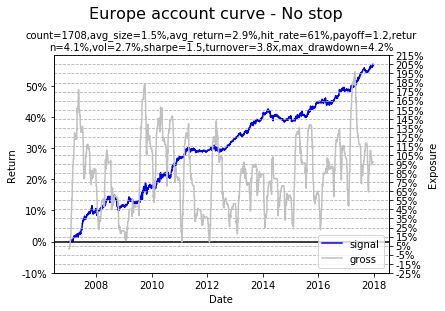

In [289]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Europe account curve - No stop",[6,4])

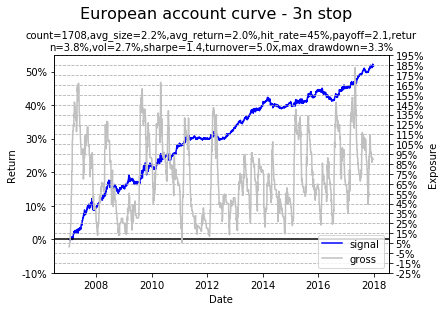

In [290]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_Europe,3,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 3n stop",[6,4])

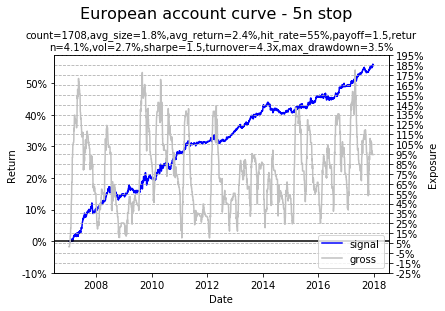

In [291]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_Europe,5,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 5n stop",[6,4])

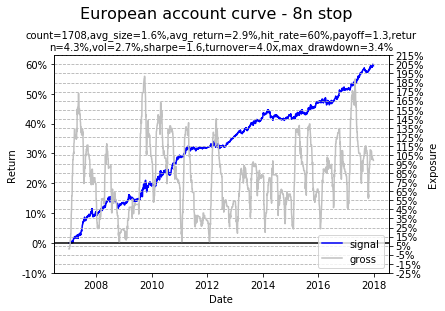

In [292]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_Europe,8,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 8n stop",[6,4])

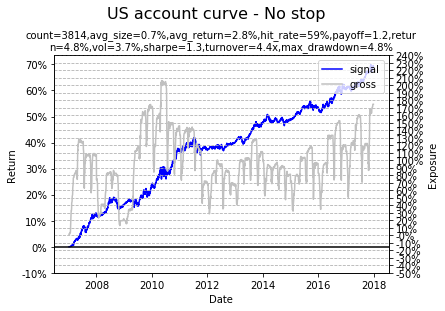

In [284]:
plot_account_curve(signal1_account(signal1_rel_df_date_US
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - No stop",[6,4])

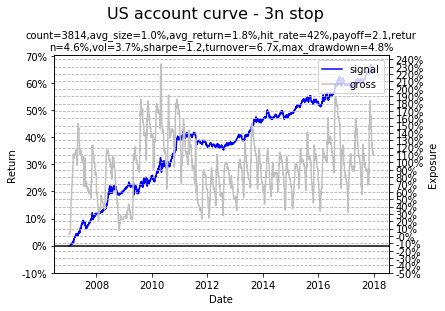

In [288]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_US,3,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 3n stop",[6,4])

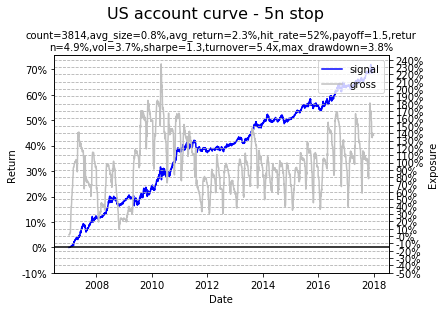

In [286]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_US,5,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 5n stop",[6,4])

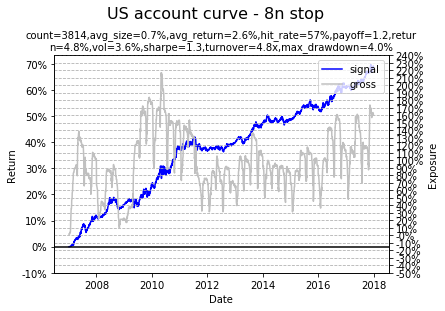

In [287]:
plot_account_curve(signal1_account(signal1_filter_stop(signal1_rel_df_date_US,8,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 8n stop",[6,4])

#### 5.8.2 Staged stop loss

In [469]:
def signal1_filter_stage_stop(signal_df,first_stop_level,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    normal_range=signal_df[signal_cum_nmove.expanding().min().shift(1,axis=0)>-first_stop_level]
    half_range=signal_df[(signal_cum_nmove.expanding().min().shift(1,axis=0)<-first_stop_level)&(signal_cum_nmove.expanding().min().shift(1,axis=0)>-stop_level)]
    signal_df_stop=normal_range.fillna(0.0)+half_range.fillna(0.0)/2
    signal_df_stop[signal_df_stop==0]=None
    return signal_df_stop

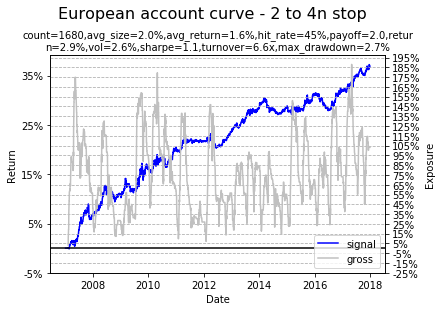

In [474]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_Europe,2,4,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 2 to 4n stop",[6,4])

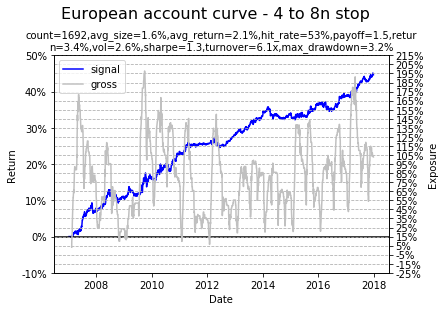

In [472]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_Europe,4,8,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 4 to 8n stop",[6,4])

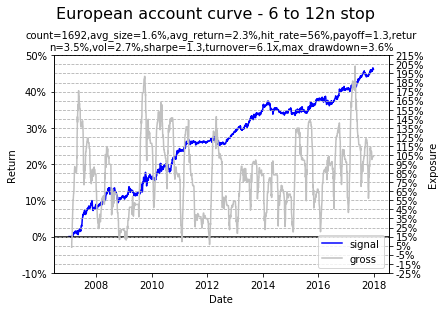

In [475]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_Europe,6,12,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 6 to 12n stop",[6,4])

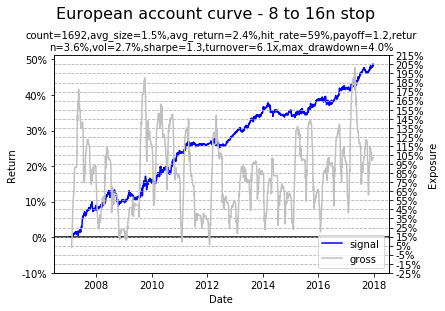

In [488]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_Europe,8,16,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 8 to 16n stop",[6,4])

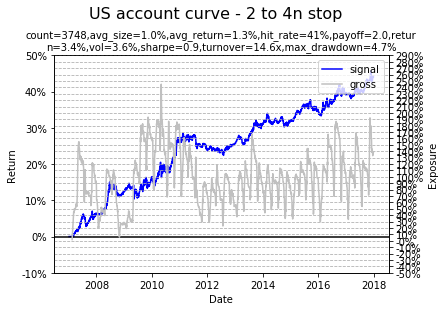

In [489]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_US,2,4,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 2 to 4n stop",[6,4])

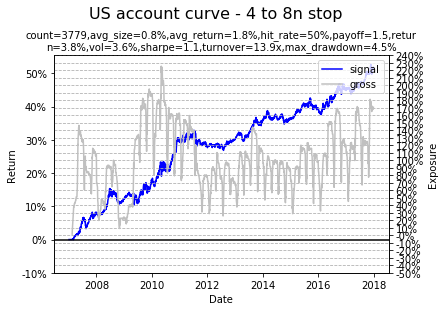

In [490]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_US,4,8,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 4 to 8n stop",[6,4])

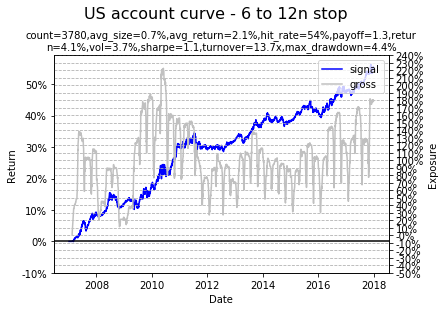

In [491]:
plot_account_curve(signal1_account(signal1_filter_stage_stop(signal1_rel_df_date_US,6,12,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 6 to 12n stop",[6,4])

#### 5.8.3 Get backto the stopped position at cost

In [744]:
def signal1_stop_back_cost(signal_df,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)|(signal_cum_nmove.shift(1,axis=0)>0)]
    return signal_df_stop

In [ ]:
+signal_df.apply(lambda column:return_df.loc[column.name[0],column.name[1]])

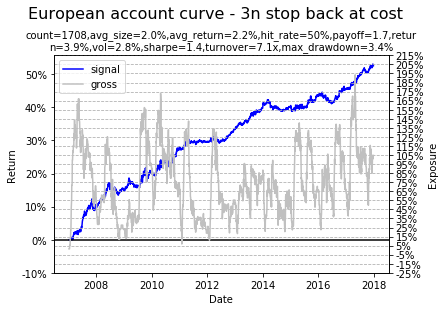

In [745]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_Europe,3,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 3n stop back at cost",[6,4])

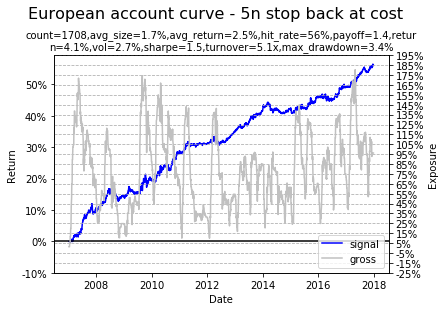

In [746]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_Europe,5,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 5n stop back at cost",[6,4])

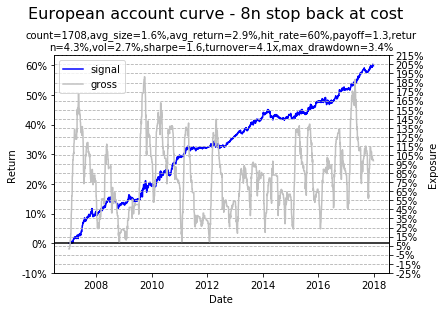

In [747]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_Europe,8,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - 8n stop back at cost",[6,4])

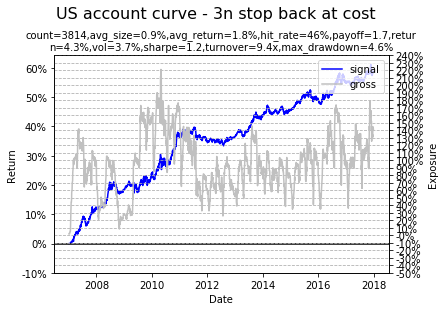

In [748]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_US,3,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 3n stop back at cost",[6,4])

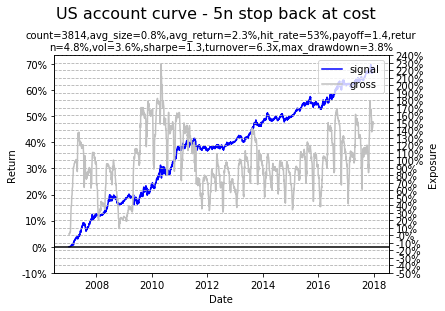

In [749]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_US,5,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 5n stop back at cost",[6,4])

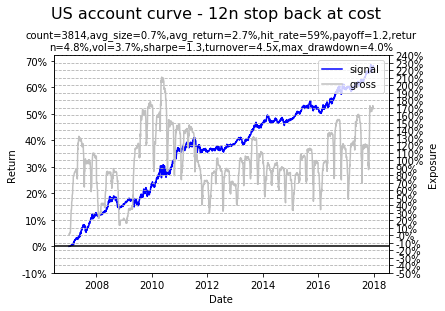

In [750]:
plot_account_curve(signal1_account(signal1_stop_back_cost(signal1_rel_df_date_US,12,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","US account curve - 12n stop back at cost",[6,4])

#### 5.8.4 stopped out when stocks break the day 1 open

In [668]:
def signal1_stop_open(signal_df,stop_level,return_df,vol_lookback):
    signal_cum=signal_df.cumsum()+signal_df.apply(lambda column:return_df.loc[column.name[0],column.name[1]])
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=signal_cum/vol_row
    signal_df_stop=signal_df[-(signal_cum_nmove.expanding().min().shift(1,axis=0)<-stop_level)]
    return signal_df_stop
    

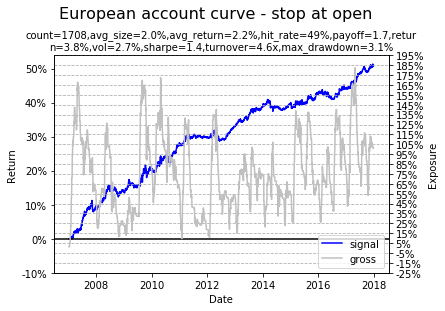

In [675]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_Europe,0,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - stop at open",[6,4])

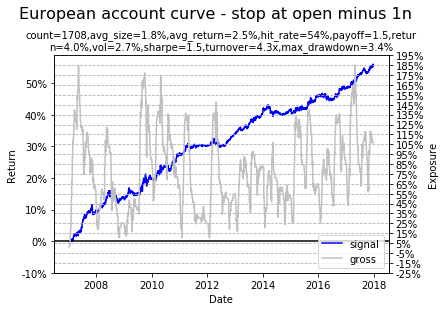

In [677]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_Europe,1,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - stop at open minus 1n",[6,4])

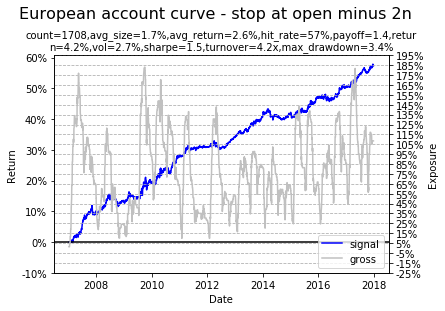

In [678]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_Europe,2,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","European account curve - stop at open minus 2n",[6,4])

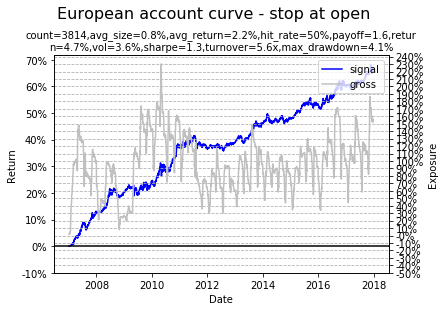

In [680]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_US,0,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","European account curve - stop at open ",[6,4])

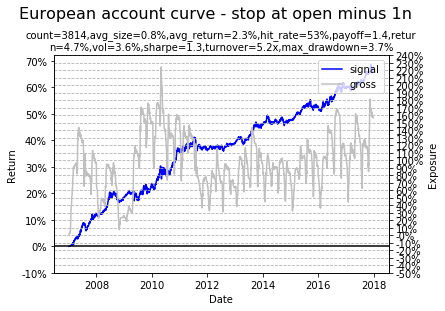

In [681]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_US,1,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","European account curve - stop at open minus 1n",[6,4])

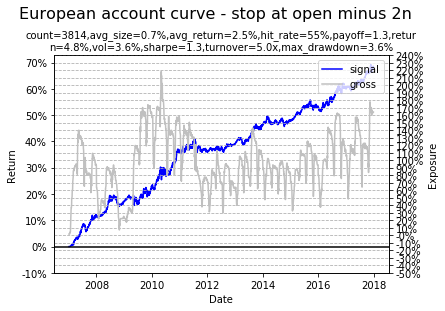

In [682]:
plot_account_curve(signal1_account(signal1_stop_open(signal1_rel_df_date_US,2,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","European account curve - stop at open minus 2n",[6,4])

### 5.9 - Account curve with drawdown stop

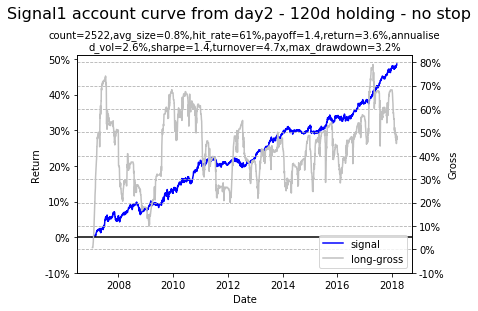

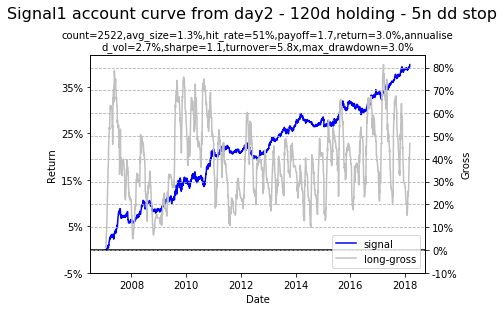

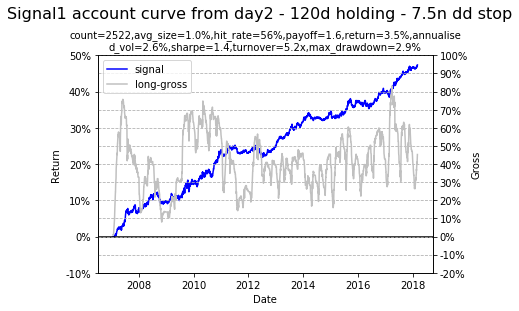

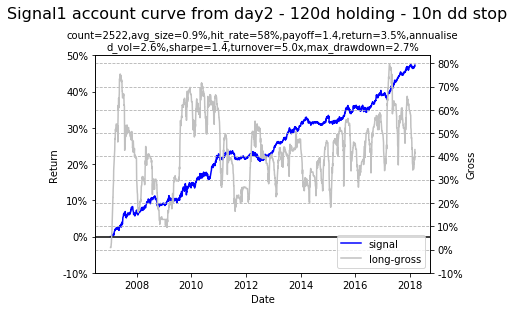

In [881]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - no stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,7.5,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 7.5n dd stop",[6,4])

plot_account_curve(signal1_account(signal1_filter_dd(signal1_rel_df_date,10,rel_return_Europe,30)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 10n dd stop",[6,4])

### 5.10 - Account curve with moving average

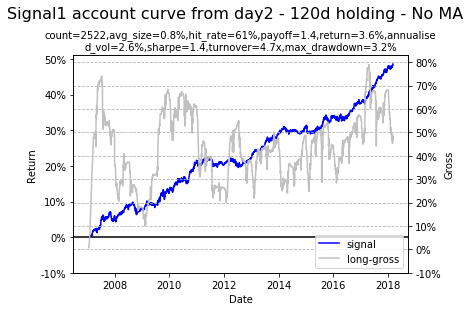

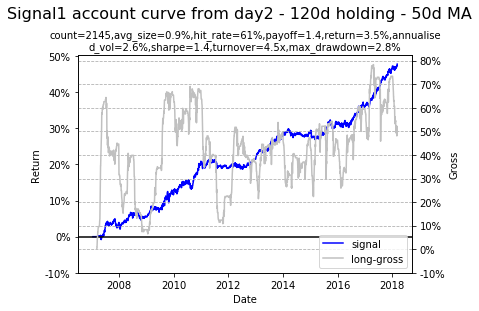

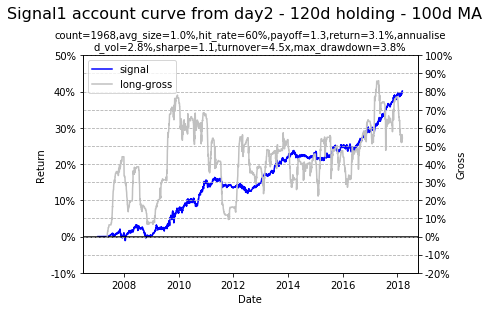

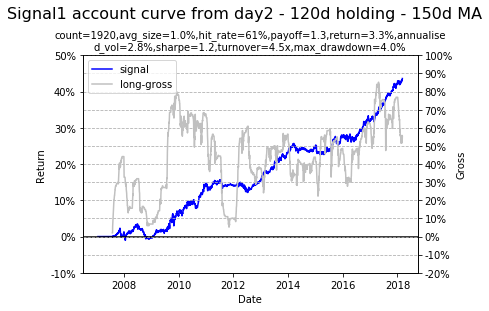

In [883]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - No MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,50)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 50d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,100)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 100d MA",[6,4])

plot_account_curve(signal1_account(signal1_filter_MA(signal1_rel_df_date,price_Europe,150)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 150d MA",[6,4])

### 5.11 - Account curve with abs/rel high

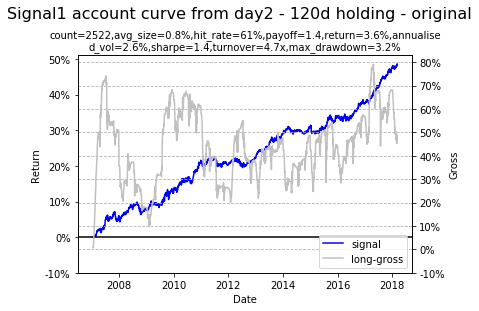

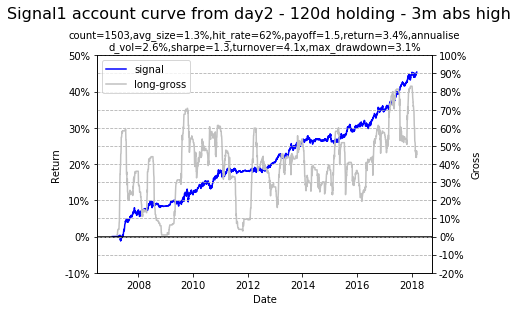

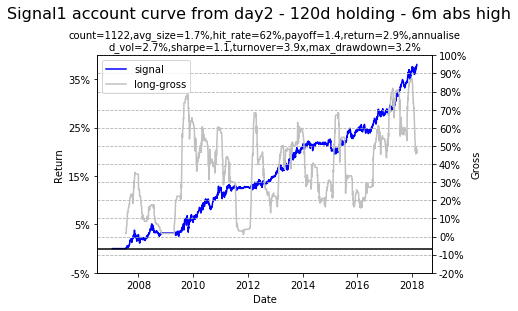

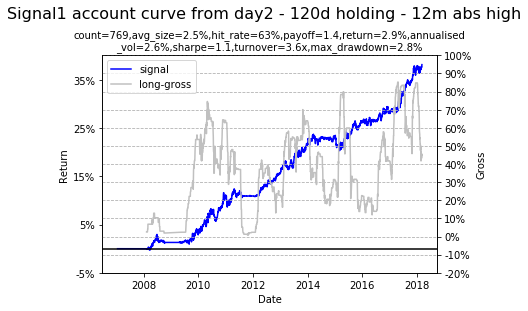

In [884]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m abs high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m abs high",[6,4])

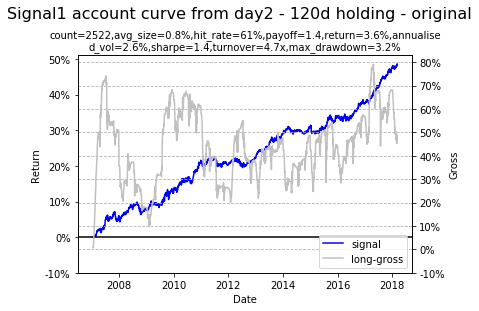

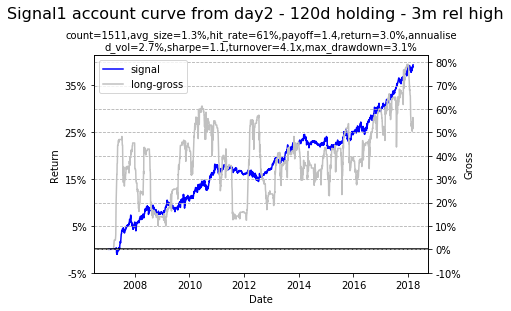

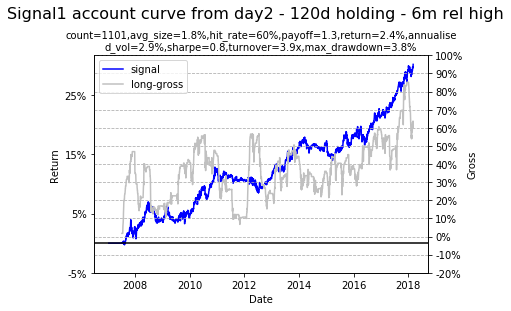

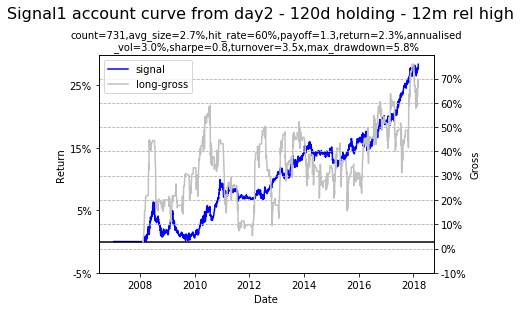

In [885]:
plot_account_curve(signal1_account(signal1_rel_df_date,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - original",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,60)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 3m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,120)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 6m rel high",[6,4])

plot_account_curve(signal1_account(signal1_filter_high(signal1_rel_df_date,rel_price_Europe,240)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day2 - 120d holding - 12m rel high",[6,4])

### 5.12 - Stress test the base case by altering earning upgrade and price move up
** BE CAREFUL WITH THIS!!! **

In [726]:
# get the revision and EAR quantile
revision_list=data_dict_Europe['Revision'].unstack(level=-1).dropna()
revision_quantile=revision_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()
EAR_full=EAR_df(data_dict_Europe["Date"],rel_return_Europe,2,30).fillna(0.0).reindex(data_dict_Europe['Revision'].index.tolist())
EAR_list=EAR_full.unstack(level=-1)[EAR_full.unstack(level=-1)!=0]
EAR_quantile=EAR_list.quantile([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]).tolist()

In [730]:
# build the monster dictionary of different scenarios of base signal, this is gonna take an hour!!!!!!!!!!!!!
EAR_upgrade_dict={}

for idx in range(len(EAR_quantile)-1):
    for i in range(len(revision_quantile)-1):
        EAR_upgrade_dict[("Move "+str(round(EAR_quantile[idx],1))+str(" to ")+str(round(EAR_quantile[idx+1],1)),
                          "Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])))]=trading_analytics_date(signal1_account(
                                    signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,EAR_quantile[idx],EAR_quantile[idx+1],data_dict['Revision'],revision_quantile[i],revision_quantile[i+1],rel_open_ret_Europe,-1000,1000,120,True,True,2)
                                   ,50,100,volume,data_dict_Europe["Date"],0.1))

In [735]:
# Build a dummy dataframe with the relevant column and index names
EAR_upgrade_df=pd.DataFrame(np.zeros((10,10)),
                  columns=["Upgrade "+str("{:.1%}".format(revision_quantile[i]))+str(" to ")+str("{:.1%}".format(revision_quantile[i+1])) for i in range(len(revision_quantile)-1)],
                  index=["Move "+str(round(EAR_quantile[i],1))+str(" to ")+str(round(EAR_quantile[i+1],1)) for i in range(len(EAR_quantile)-1)])

In [770]:
# fill in relevant sharpe data
EAR_upgrade_sharpe=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_sharpe.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_sharpe.columns.tolist()):
        EAR_upgrade_sharpe.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][5],2)

In [788]:
# fill in relevant return data
EAR_upgrade_ret=EAR_upgrade_df.copy()
for i,ival in enumerate(EAR_upgrade_ret.index.tolist()):
    for j,jval in enumerate(EAR_upgrade_ret.columns.tolist()):
        EAR_upgrade_ret.iloc[i,j]=round(EAR_upgrade_dict[(ival,jval)][3],3)

### 5.13 -  Market correlation

In [155]:
# Signal account curve
account_rel_Europe=signal1_account(signal1_rel_df_date_Europe,50,100,volume,data_dict_Europe["Date"],0.1)[0]
account_rel_Europe.name="Signal1 Europe rel"
account_abs_Europe=signal1_account(signal1_abs_df_date_Europe,100,100,volume,data_dict_Europe["Date"],0.1)[0]
account_abs_Europe.name="Signal1 Europe abs"
account_rel_US=signal1_account(signal1_rel_df_date_US,50,100,volume_US,data_dict_US["Date"],0.1)[0]
account_rel_US.name="Signal1 US rel"
account_abs_US=signal1_account(signal1_abs_df_date_US,100,100,volume_US,data_dict_US["Date"],0.1)[0]
account_abs_US.name="Signal1 US abs"
account_rel_global=signal1_account(signal1_rel_df_date_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_rel_global.name="Signal1 US+Europe rel"
account_abs_global=signal1_account(signal1_rel_df_date_global,100,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)[0]
account_abs_global.name="Signal1 US+Europe abs"

In [156]:
account_df=pd.concat([account_rel_Europe,account_abs_Europe,account_rel_US,account_abs_US,
                     account_rel_global,account_abs_global],axis=1)

In [157]:
# Market
account_SXXP=(1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1
account_momentum_Europe=(1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1
account_momentum_US=(1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1
account_SPX=(1+abs_return_US.loc["SPX Index"]).cumprod()-1
index_df=pd.concat([account_SXXP,account_momentum_Europe,account_momentum_US,account_SPX],axis=1)
index_df=index_df.reindex([datetime.strptime(x,"%d/%b/%Y") for x in index_df.index]).sort_index()

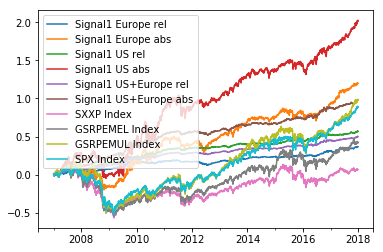

In [158]:
# Add them together and plot
account_combined=pd.concat([account_df,index_df],axis=1)
account_combined.plot()

In [159]:
# Correlation matrix
account_combined.corr()

Signal1 Europe rel  Signal1 Europe abs  Signal1 US rel  \
Signal1 Europe rel               1.000000            0.942117        0.966523   
Signal1 Europe abs               0.942117            1.000000        0.939763   
Signal1 US rel                   0.966523            0.939763        1.000000   
Signal1 US abs                   0.942105            0.989204        0.966108   
Signal1 US+Europe rel            0.981844            0.946971        0.997635   
Signal1 US+Europe abs            0.981505            0.945892        0.997744   
SXXP Index                       0.387995            0.621761        0.338346   
GSRPEMEL Index                   0.616179            0.803826        0.583306   
GSRPEMUL Index                   0.741499            0.885761        0.715978   
SPX Index                        0.783453            0.908748        0.752799   

                       Signal1 US abs  Signal1 US+Europe rel  \
Signal1 Europe rel           0.942105               0.981844   
Signal1 Europe abs           0.989204               0.946971   
Signal1 US rel               0.966108               0.997635   
Signal1 US abs               1.000000               0.966362   
Signal1 US+Europe rel        0.966362               1.000000   
Signal1 US+Europe abs        0.965560               0.999985   
SXXP Index                   0.547972               0.355278   
GSRPEMEL Index               0.753980               0.597216   
GSRPEMUL Index               0.858113               0.728458   
SPX Index                    0.879821               0.767013   

                       Signal1 US+Europe abs  SXXP Index  GSRPEMEL Index  \
Signal1 Europe rel                  0.981505    0.387995        0.616179   
Signal1 Europe abs                  0.945892    0.621761        0.803826   
Signal1 US rel                      0.997744    0.338346        0.583306   
Signal1 US abs                      0.965560    0.547972        0.753980   
Signal1 US+Europe rel               0.999985    0.355278        0.597216   
Signal1 US+Europe abs               1.000000    0.351636        0.593859   
SXXP Index                          0.351636    1.000000        0.946136   
GSRPEMEL Index                      0.593859    0.946136        1.000000   
GSRPEMUL Index                      0.725399    0.853733        0.969108   
SPX Index                           0.764129    0.835293        0.959373   

                       GSRPEMUL Index  SPX Index  
Signal1 Europe rel           0.741499   0.783453  
Signal1 Europe abs           0.885761   0.908748  
Signal1 US rel               0.715978   0.752799  
Signal1 US abs               0.858113   0.879821  
Signal1 US+Europe rel        0.728458   0.767013  
Signal1 US+Europe abs        0.725399   0.764129  
SXXP Index                   0.853733   0.835293  
GSRPEMEL Index               0.969108   0.959373  
GSRPEMUL Index               1.000000   0.993442  
SPX Index                    0.993442   1.000000

### 5.14 - Performance over subsequent quarters

In [658]:
signal1_follow_US=signal1_follow(signal1_US,data_dict_US["Date"],10)
signal1_follow=signal1_follow(signal1,data_dict_Europe["Date"],10)

In [660]:
follow_US=signal1_follow_EAR(signal1_follow_US,abs_return_US,2,30)
follow=signal1_follow_EAR(signal1_follow,abs_return_Europe,2,30)

C:\Users\Eric.Li\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


In [661]:
follow_US=follow_US.sort_values(by='Quarter+0',axis=1)
follow=follow.sort_values(by='Quarter+0',axis=1)

### 5.15 - Account curve with gap filter

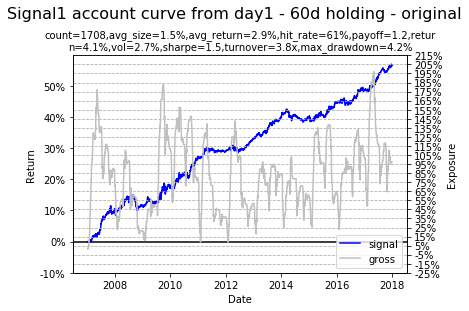

In [691]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day1 - 60d holding - original",[6,4])

#### 5.15.1 intraday move on the performance of the signal

In [251]:
# Start with Europe
gap_info_Europe=signal1_rel_df_date_Europe.apply(lambda column:gap_calc(column.name[0],column.name[1],rel_open_ret_Europe,rel_return_Europe,30)).sort_values()
gap_info_Europe.name="gap"
EAR_info_Europe=signal1_rel_df_date_Europe.apply(lambda column:EAR_calc(column.name[0],column.name[1],rel_return_Europe,1,30)).sort_values()
EAR_info_Europe.name="EAR"
ret_info_Europe=signal1_rel_df_date_Europe.cumsum().ffill().iloc[-1].sort_values()
ret_info_Europe.name="Return"
intraday_df_Europe=ret_info_Europe.to_frame().copy()
intraday_df_Europe["EAR"]=EAR_info_Europe
intraday_df_Europe["gap"]=gap_info_Europe
intraday_df_Europe["diff"]=intraday_df_Europe["EAR"]-intraday_df_Europe["gap"]

In [ ]:
# For US
gap_info_US=signal1_rel_df_date_US.apply(lambda column:gap_calc(column.name[0],column.name[1],rel_open_ret_US,rel_return_US,30)).sort_values()
gap_info_US.name="gap"
EAR_info_US=signal1_rel_df_date_US.apply(lambda column:EAR_calc(column.name[0],column.name[1],rel_return_US,1,30)).sort_values()
EAR_info_US.name="EAR"
ret_info_US=signal1_rel_df_date_US.cumsum().ffill().iloc[-1].sort_values()
ret_info_US.name="Return"
intraday_df_US=ret_info_US.to_frame().copy()

intraday_df_US["EAR"]=EAR_info_US
intraday_df_US["gap"]=gap_info_US
intraday_df_US["diff"]=intraday_df_US["EAR"]-intraday_df_US["gap"]

In [268]:
intraday_df_Europe["gap"].quantile([0,0.14,0.28,0.42,0.56,0.7,0.84,1])

0.00    -3.969026
0.14     0.184470
0.28     0.750482
0.42     1.401970
0.56     2.075647
0.70     2.911475
0.84     4.163904
1.00    14.776584
Name: gap, dtype: float64

In [269]:
intraday_df_US["gap"].quantile([0,0.14,0.28,0.42,0.56,0.7,0.84,1])

0.00    -7.291252
0.14     0.843443
0.28     1.926004
0.42     2.842433
0.56     3.838792
0.70     5.073271
0.84     6.913114
1.00    33.013583
Name: gap, dtype: float64

In [372]:
(intraday_df_US["gap"]>0).sum()/len(intraday_df_US["gap"])

0.9444153120083901

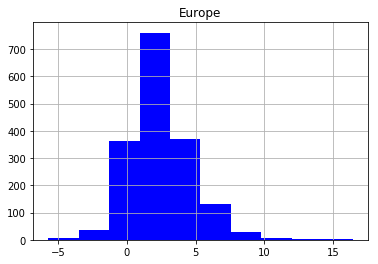

In [352]:
fig,ax=plt.subplots()
ax.hist(intraday_df_Europe["diff"],color='blue')
ax.set_title("Europe")
ax.grid()

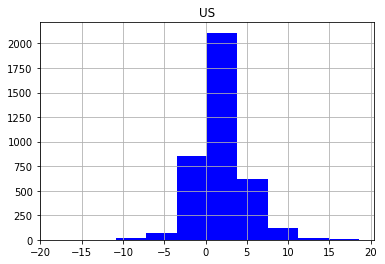

In [361]:
fig2,ax2=plt.subplots()
ax2.hist(intraday_df_US["diff"].dropna(),color='blue')
ax2.set_title("US")
ax2.grid()

#### 5.15.2 add gap filter on the base signal

In [383]:
my_index=["Mean return","Count","Hit rate","Payoff ratio"]

In [279]:
intraday_df_Europe["gap"].quantile([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])

0.000    -3.969026
0.125     0.115805
0.250     0.623583
0.375     1.188675
0.500     1.741480
0.625     2.405409
0.750     3.296688
0.875     4.569659
1.000    14.776584
Name: gap, dtype: float64

In [277]:
gap_Europe=pd.DataFrame(index=my_index)
gap_Europe["Gap down"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,-1000,0.1,30))]
gap_Europe["Gap 0-0.6n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,0.1,0.6,30))]
gap_Europe["Gap 0.6-1.2n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,0.6,1.2,30))]
gap_Europe["Gap 1.2-1.7n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,1.2,1.7,30))]
gap_Europe["Gap 1.7-2.4n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,1.7,2.4,30))]
gap_Europe["Gap 2.4-3.3n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,2.4,3.3,30))]
gap_Europe["Gap 3.3-4.5n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,3.3,4.6,30))]
gap_Europe["Gap > 4.5n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,4.6,1000,30))]

In [280]:
intraday_df_US["gap"].quantile([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])

0.000    -7.291252
0.125     0.731595
0.250     1.721805
0.375     2.551017
0.500     3.401365
0.625     4.292516
0.750     5.639875
0.875     7.538770
1.000    33.013583
Name: gap, dtype: float64

In [281]:
gap_US=pd.DataFrame(index=gap_index)
gap_US["Gap down"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,-1000,0.7,30))]
gap_US["Gap 0.7-1.7n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,0.7,1.7,30))]
gap_US["Gap 0.7-2.5n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,1.7,2.5,30))]
gap_US["Gap 2.5-3.4n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,2.5,3.4,30))]
gap_US["Gap 3.4-4.3n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,3.4,4.3,30))]
gap_US["Gap 4.3-5.6n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,4.3,5.6,30))]
gap_US["Gap 5.6-7.5n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,5.6,7.5,30))]
gap_US["Gap > 7.5n"]=[x for x in trading_analytics_day(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,7.5,1000,30))]

AttributeError: module 'matplotlib.pyplot' has no attribute 'title'

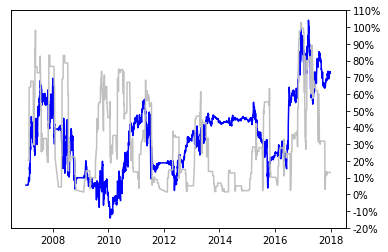

In [351]:
plot_account_curve(signal1_account(signal1_filter_gap(signal1_rel_df_date_Europe,rel_open_ret_Europe,rel_return_Europe,1.7,2.4,30),50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 account curve from day1 - 60d holding - original",[6,4])

AttributeError: module 'matplotlib.pyplot' has no attribute 'title'

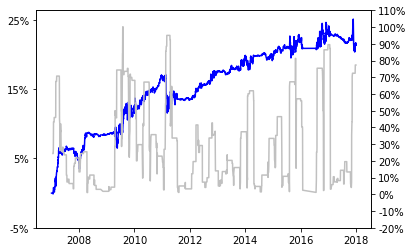

In [350]:
plot_account_curve(signal1_account(signal1_filter_gap(signal1_rel_df_date_US,rel_open_ret_US,rel_return_US,-1000,0,30),50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 account curve from day1 - 60d holding - original",[6,4])

#### 5.15.3 use gap instead of move up

In [ ]:
gap_index=["Mean return","Count","Hit rate","Payoff ratio"]

In [366]:
gap_df_Europe=gap_df(data_dict_Europe["Date"], rel_open_ret_Europe, rel_return_Europe, 30)
gap_df_US=gap_df(data_dict_US["Date"], rel_open_ret_US, rel_return_US, 30)

In [379]:
gap_df_Europe[data_dict_Europe["Revision"]>0.02].unstack(-1).dropna().quantile([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])

0.000     -10.4435
0.125     -1.25795
0.250    -0.403704
0.375   -0.0586303
0.500     0.194515
0.625     0.568373
0.750      1.07161
0.875      1.96484
1.000      15.8581
dtype: object

In [381]:
gap_df_US[data_dict_US["Revision"]>0.05].unstack(-1).dropna().quantile([0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1])

0.000    -46.6386
0.125    -3.15531
0.250    -1.21438
0.375   -0.355206
0.500    0.154943
0.625    0.817088
0.750     1.81964
0.875     3.51936
1.000     20.7547
dtype: object

In [385]:
gap_signal_Europe=pd.DataFrame(index=my_index)
gap_signal_Europe["Gap down > 1.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1000,-1.25,60,False,False,1))]
gap_signal_Europe["Gap down 0.5-1.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-1.25,-0.4,60,False,False,1))]
gap_signal_Europe["Gap down 0-0.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-0.4,-0.05,60,False,False,1))]
gap_signal_Europe["Gap 0-0.2n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,-0.05,0.19,60,False,False,1))]
gap_signal_Europe["Gap 0.2-0.6n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,0.19,0.57,60,False,False,1))]
gap_signal_Europe["Gap 0.6-1n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,0.57,1.1,60,False,False,1))]
gap_signal_Europe["Gap 1-2n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,1.1,2,60,False,False,1))]
gap_signal_Europe["Gap > 2n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,2,1000,60,False,False,1))]


In [389]:
gap_signal_US

Gap down > 3n  Gap down 1-3n  Gap down 0-1n   Gap 0-0.5n  \
Mean return        0.014345       0.015252       0.015487     0.019497   
Count            468.000000     964.000000    1263.000000  1329.000000   
Hit rate           0.529915       0.525934       0.536817     0.546275   
Payoff ratio       1.187402       1.211257       1.155742     1.194459   

              Gap 0.5-0.8n  Gap 0.8-1.8n  Gap 1.8-3.5n   Gap > 3.5n  
Mean return       0.020636      0.021073      0.017245     0.019331  
Count          1913.000000   2539.000000   2969.000000  3695.000000  
Hit rate          0.548876      0.551004      0.562816     0.574290  
Payoff ratio      1.227726      1.236666      1.132493     1.180992

In [390]:
gap_signal_US=pd.DataFrame(index=my_index)
gap_signal_US["Gap down > 3n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-1000,-3.1,60,False,False,1))]
gap_signal_US["Gap down 1-3n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-3.1,-1.2,60,False,False,1))]
gap_signal_US["Gap down 0-1n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-1.2,-0.3,60,False,False,1))]
gap_signal_US["Gap 0-0.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,-0.3,0.15,60,False,False,1))]
gap_signal_US["Gap 0.5-0.8n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,0.15,0.8,60,False,False,1))]
gap_signal_US["Gap 0.8-1.8n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,0.8,1.8,60,False,False,1))]
gap_signal_US["Gap 1.8-3.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,1.8,3.5,60,False,False,1))]
gap_signal_US["Gap > 3.5n"]=[x for x in trading_analytics_day(signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,3.5,1000,60,False,False,1))]


In [131]:
gap_signal_Europe

Gap down     Gap 0-2n    Gap 2-4n    Gap 4-6n    Gap > 6n
Mean return      0.033152     0.028460    0.025189    0.024701    0.019234
Count         1109.000000  2356.000000  712.000000  216.000000  101.000000
Hit rate         0.626691     0.604839    0.592697    0.615741    0.603960
Payoff ratio     1.265061     1.207728    1.219368    1.225829    1.041009

In [391]:
gap_signal_US

Gap down > 3n  Gap down 1-3n  Gap down 0-1n  Gap 0-0.5n  \
Mean return        0.017586       0.017535       0.024035    0.027064   
Count            204.000000     471.000000     633.000000  665.000000   
Hit rate           0.534314       0.511677       0.551343    0.557895   
Payoff ratio       1.198305       1.276811       1.193987    1.215711   

              Gap 0.5-0.8n  Gap 0.8-1.8n  Gap 1.8-3.5n   Gap > 3.5n  
Mean return       0.028278      0.030649      0.023387     0.026758  
Count           968.000000   1275.000000   1483.000000  2064.000000  
Hit rate          0.550620      0.561569      0.571814     0.597868  
Payoff ratio      1.320404      1.318972      1.187080     1.217562

#### 5.15.4 case for intraday reversal

In [404]:
intraday_reversal_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,1000,data_dict_Europe['Revision'],0.02,1000,rel_open_ret_Europe,2,1000,60,False,False,1)
intraday_reversal_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,1000,data_dict_US['Revision'],0.05,1000,rel_open_ret_US,4,1000,60,False,False,1)

In [407]:
intraday_gap_info_US=intraday_reversal_US.apply(lambda column:gap_calc(column.name[0],column.name[1],rel_open_ret_US,rel_return_US,30)).sort_values()
intraday_gap_info_US.name="gap"
intraday_EAR_info_US=intraday_reversal_US.apply(lambda column:EAR_calc(column.name[0],column.name[1],rel_return_US,1,30)).sort_values()
intraday_EAR_info_US.name="EAR"
intraday_ret_info_US=intraday_reversal_US.cumsum().ffill().iloc[-1].sort_values()
intraday_ret_info_US.name="Return"
reversal_df_US=intraday_ret_info_US.to_frame().copy()

reversal_df_US["EAR"]=intraday_EAR_info_US
reversal_df_US["gap"]=intraday_gap_info_US
reversal_df_US["diff"]=reversal_df_US["EAR"]-reversal_df_US["gap"]

In [431]:
reversal_df_US["diff"].mean()

0.5504942965209176

In [439]:
len(reversal_df_Europe[reversal_df_Europe["diff"]<-2])/len(reversal_df_Europe["diff"])

0.1454898157129001

In [440]:
len(reversal_df_US[reversal_df_US["diff"]<-2])/len(reversal_df_US["diff"])

0.22473867595818817

In [409]:
intraday_gap_info_Europe=intraday_reversal_Europe.apply(lambda column:gap_calc(column.name[0],column.name[1],rel_open_ret_Europe,rel_return_Europe,30)).sort_values()
intraday_gap_info_Europe.name="gap"
intraday_EAR_info_Europe=intraday_reversal_Europe.apply(lambda column:EAR_calc(column.name[0],column.name[1],rel_return_Europe,1,30)).sort_values()
intraday_EAR_info_Europe.name="EAR"
intraday_ret_info_Europe=intraday_reversal_Europe.cumsum().ffill().iloc[-1].sort_values()
intraday_ret_info_Europe.name="Return"
reversal_df_Europe=intraday_ret_info_Europe.to_frame().copy()

reversal_df_Europe["EAR"]=intraday_EAR_info_Europe
reversal_df_Europe["gap"]=intraday_gap_info_Europe
reversal_df_Europe["diff"]=reversal_df_Europe["EAR"]-reversal_df_Europe["gap"]

In [442]:
reversal_df_Europe[reversal_df_Europe["EAR"]<0]["Return"].mean()

-0.003829685340088161

In [443]:
reversal_df_Europe[reversal_df_Europe["diff"]>0]["Return"].mean()

0.028122812112944512

In [441]:
reversal_df_US[reversal_df_US["EAR"]<0]["Return"].mean()

0.03199242954371346

In [444]:
reversal_df_US[reversal_df_US["diff"]>0]["Return"].mean()

0.03437047453938021

### 5.16 Sizing and scaling the portfolio

#### 5.16.1Size the positions by volatility

In [731]:
def signal1_account_parity(signal_df, return_df,average_gross, capital, volume_df, date_df, liquidity_constraint):
    average_number=signal_df.count(axis=1).mean()
    avg_size=average_gross/100/average_number   
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,30),axis=0)
    size_row=signal_df.apply(lambda x: min(avg_size/(vol_row[x.name]/vol_row.mean()),get_volume(x.name[0],x.name[1],volume_df,date_df)*liquidity_constraint/capital))
    count=signal_df.copy()
    count[(count>=0)|(count<0)]=1.0
    avg_holding=count.sum(axis=0).mean()
    gross=(count*size_row).sum(axis=1)*2
    gross=gross[gross!=0]
    account_curve=(((signal_df+1).cumprod()-1)*size_row).ffill().sum(axis=1)
    ind_return=(((signal_df+1).cumprod()-1)*size_row).ffill().iloc[-1].dropna()
    stock_return=((signal_df+1).cumprod()-1).ffill().iloc[-1].dropna()
    turnover=np.abs((count*size_row).fillna(0.0).diff(1)).sum().sum()/(count.shape[0]/260)
    return account_curve,avg_size,gross,ind_return,turnover,avg_holding,stock_return

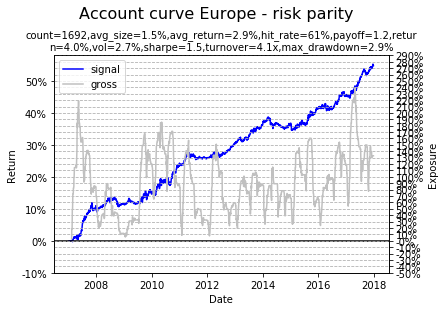

In [735]:
plot_account_curve(signal1_account_parity(signal1_rel_df_date_Europe,rel_return_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Account curve Europe - risk parity",[6,4])

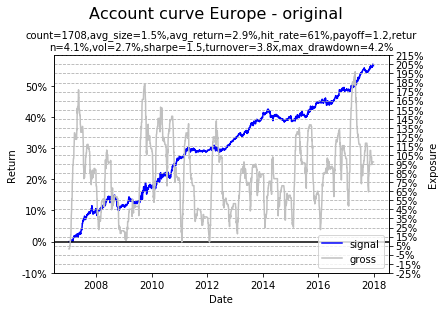

In [736]:
plot_account_curve(signal1_account(signal1_rel_df_date_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Account curve Europe - original",[6,4])

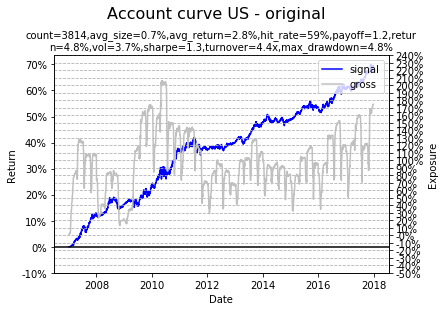

In [752]:
plot_account_curve(signal1_account(signal1_rel_df_date_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Account curve US - original",[6,4])

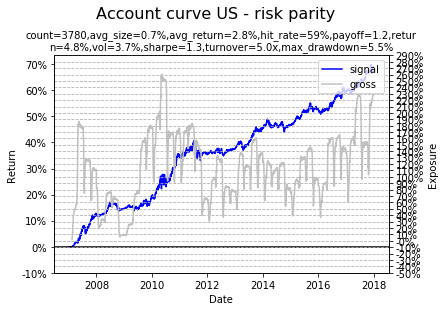

In [753]:
plot_account_curve(signal1_account_parity(signal1_rel_df_date_US,rel_return_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Account curve US - risk parity",[6,4])

#### 5.16.2 Scale up the winning position

In [768]:
test_scaling_Europe=signal1_winner_scaling(signal1_rel_df_date_Europe,3,rel_return_Europe,30)

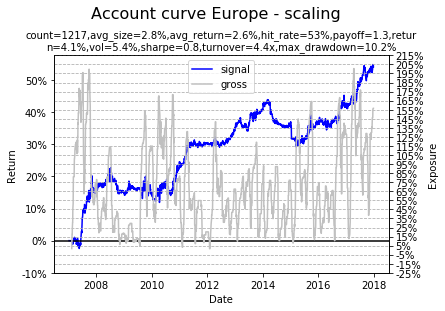

In [769]:
plot_account_curve(signal1_account_parity(test_scaling_Europe,rel_return_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Account curve Europe - scaling",[6,4])

In [765]:
def signal1_winner_scaling(signal_df,add_level,stop_level,return_df,vol_lookback):
    vol_row=signal_df.apply(lambda column:signal1_vol(column,return_df,vol_lookback),axis=0)
    signal_cum_nmove=((1+signal_df).cumprod()-1).ffill()/vol_row
    add_range=signal_df[signal_cum_nmove.expanding().max().shift(1,axis=0)>add_level]
    signal_df_scaling=signal_df+add_range
    return signal_df_scaling

## 6 - Average return trajectory for short

In [51]:
# obtain the short signals
signal1_short_Europe,signal1_short_next_Europe=signal1_formation(data_dict_Europe['Date'],rel_return_Europe,2,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,rel_open_ret_Europe,-1000,1000)
signal1_short_US,signal1_short_next_US=signal1_formation(data_dict_US['Date'],rel_return_US,2,-1000,-2,data_dict_US['Revision'],-1000,-0.05,rel_open_ret_US,-1000,1000)

In [52]:
# Short signal dataframe
signal1_short_abs_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,abs_return_Europe,120,True,2)
signal1_short_rel_df_Europe=signal1_df_day(signal1_short_Europe,signal1_short_Europe_next,rel_return_Europe,120,True,2)

signal1_short_abs_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,120,True,2)
signal1_short_rel_df_US=signal1_df_day(signal1_short_US,signal1_short_next_US,rel_return_US,120,True,2)

NameError: name 'signal1_short_Europe_next' is not defined

In [ ]:
# Europe signal list
signal1_short_list_rel_Europe=((1+signal1_short_rel_df_Europe).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_Europe.sort_values()

In [ ]:
# US signal list
signal1_short_list_rel_US=((1+signal1_short_rel_df_US).cumprod(axis=0)-1).ffill().iloc[-1]
signal1_short_list_rel_US.sort_values()

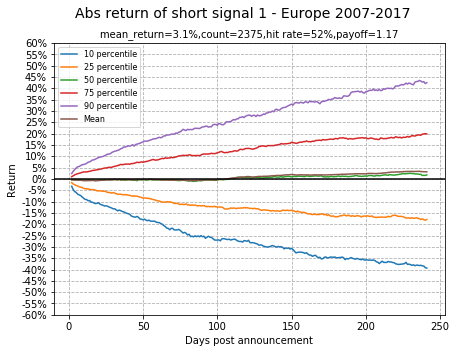

In [184]:
perf_chart_day(signal1_df_day(signal1_short_Europe,signal1_short_next_Europe,abs_return_Europe,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - Europe 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

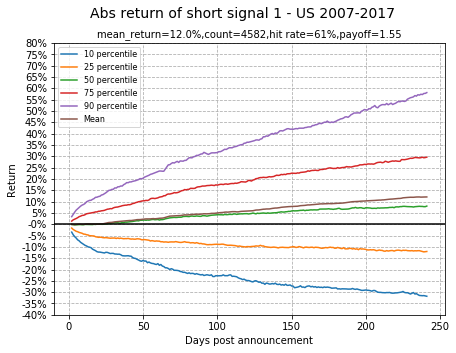

In [187]:
perf_chart_day(signal1_df_day(signal1_short_US,signal1_short_next_US,abs_return_US,240,True,2)
               ,"Days post announcement","Return","Abs return of short signal 1 - US 2007-2017",[7,5],
               [0.1,0.25,0.5,0.75,0.9])

## 7 - Account curve for short

Simulated performance of the portfolio by actual dates
- Basic plot by holding period and next result
- By entry point
- By size
- By PE and PE premium
- By sectors
- Stop loss
- Performance for the following results

### 7.1 - Basic plot by holding period and next result

In [53]:
# singal1 short dataframe by actual date US
signal1_rel_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,rel_open_ret_US,-1000,1000,60,False,False,1)
signal1_abs_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,abs_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,abs_open_ret_US,-1000,1000,60,False,False,1)

In [54]:
# singal1 short dataframe by actual date Europe
signal1_rel_df_date_short_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,rel_open_ret_Europe,-1000,1000,60,False,False,1)
signal1_abs_df_date_short_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,abs_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,abs_open_ret_Europe,-1000,1000,60,False,False,1)

In [55]:
# combine the US and Europe
signal1_rel_df_date_short_global=pd.concat([signal1_rel_df_date_short_US,signal1_rel_df_date_short_Europe],axis=1)
signal1_abs_df_date_short_global=pd.concat([signal1_abs_df_date_short_US,signal1_abs_df_date_short_Europe],axis=1)

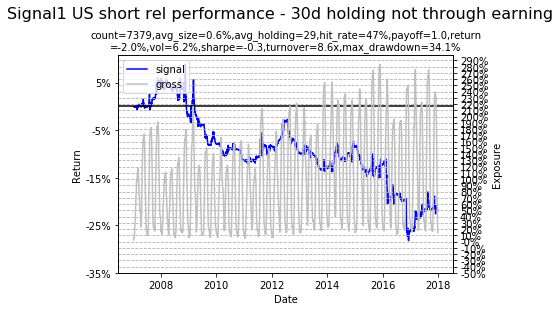

In [56]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,rel_open_ret_US,-1000,1000,30,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding not through earning",[6,4])

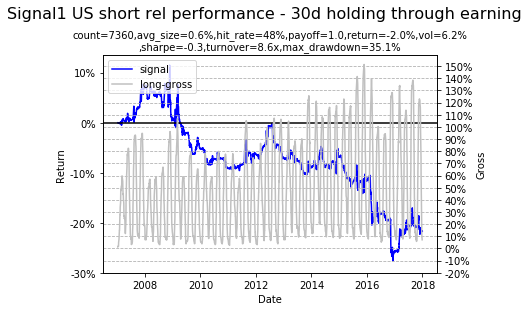

In [587]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,rel_open_ret_US,-1000,1000,-0.02,30,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 30d holding through earning",[6,4])

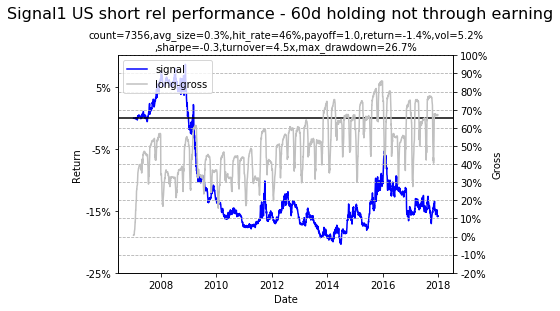

In [588]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,rel_open_ret_US,-1000,1000,,60,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding not through earning",[6,4])

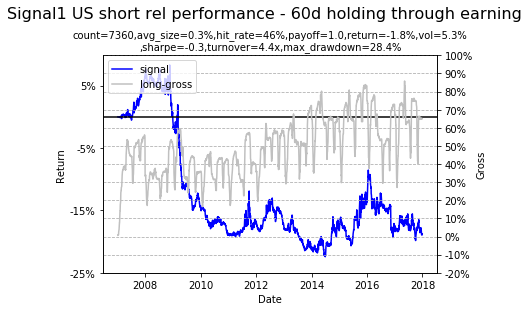

In [592]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,rel_open_ret_US,-1000,1000,60,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 60d holding through earning",[6,4])

In [ ]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding not through earning",[6,4])

In [ ]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,True,True,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding through earning",[6,4])

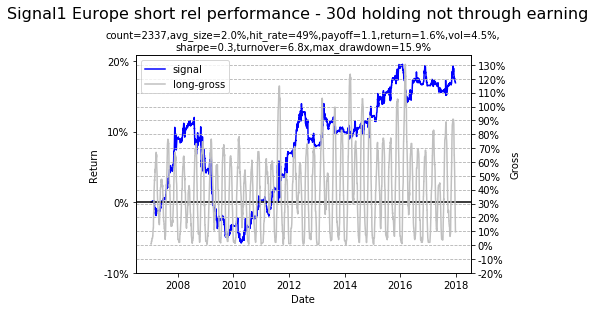

In [312]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,30,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 30d holding not through earning",[6,4])

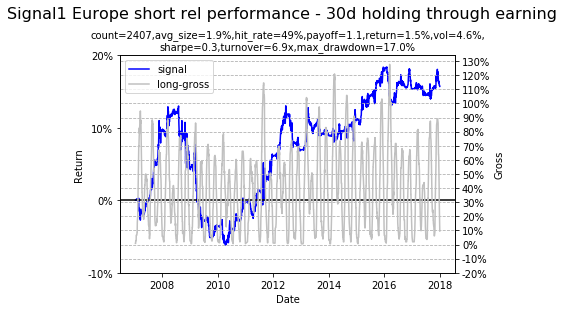

In [313]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,30,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 30d holding through earning",[6,4])

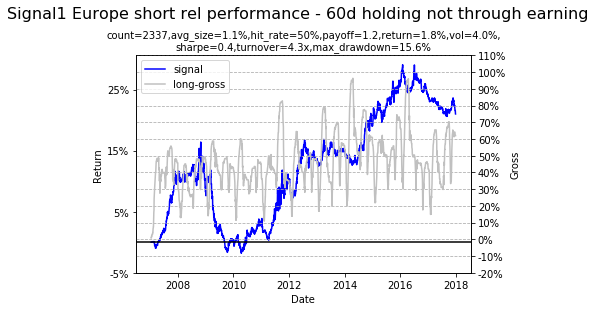

In [311]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,60,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 60d holding not through earning",[6,4])

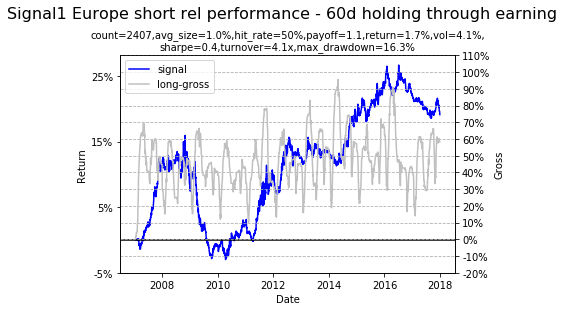

In [314]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,60,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 60d holding through earning",[6,4])

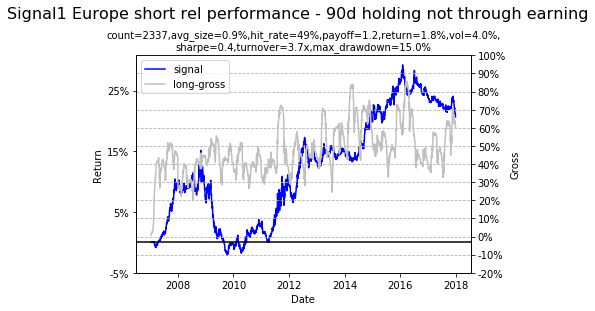

In [315]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 90d holding not through earning",[6,4])

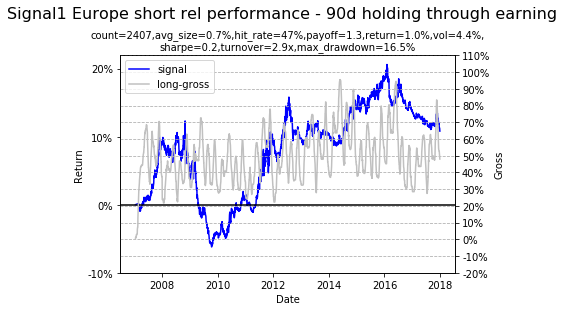

In [316]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,90,True,True,2)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short rel performance - 90d holding through earning",[6,4])

### 7.2 - Short signal performance by entry point

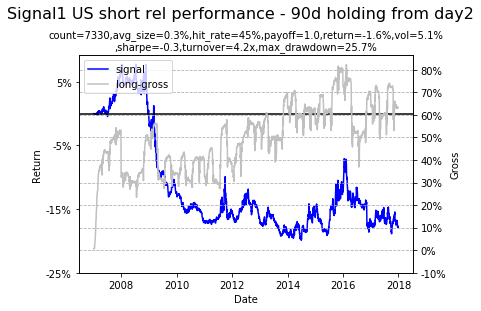

In [303]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,2)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding from day2",[6,4])

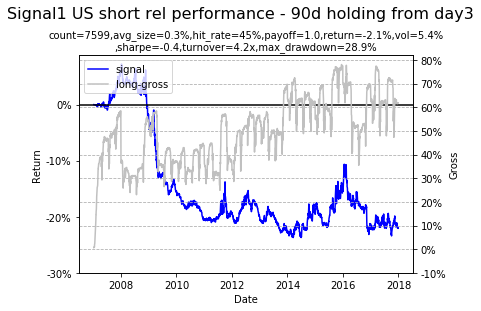

In [304]:
plot_account_curve(signal1_account(-signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,90,False,False,3)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 US short rel performance - 90d holding from day3",[6,4])

### 7.3 - Short account curve by size

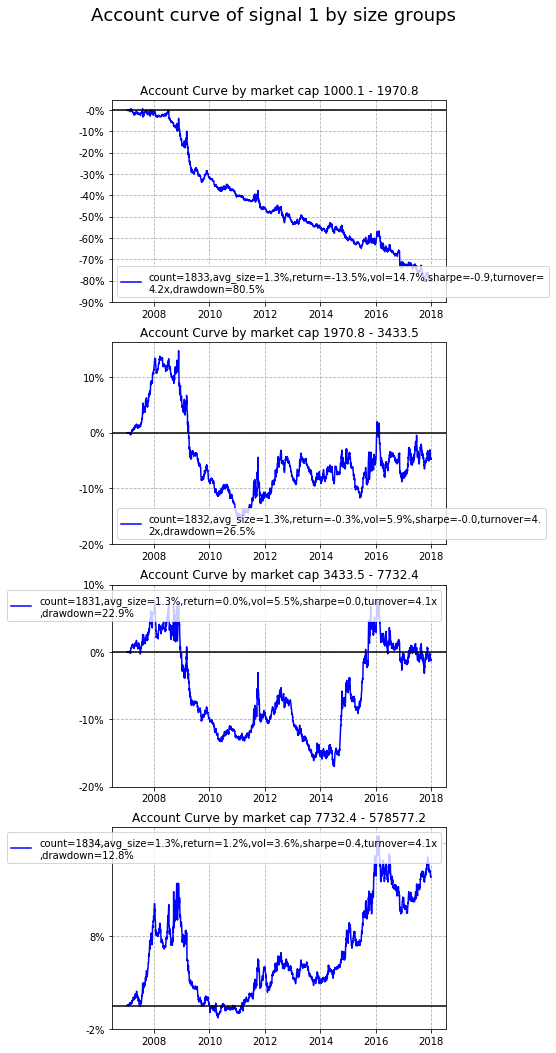

In [267]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,26),18,
                            "Account curve of signal 1 by size groups",-signal1_rel_df_date_short_US,
                            50,30,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["Market cap"],0.1)

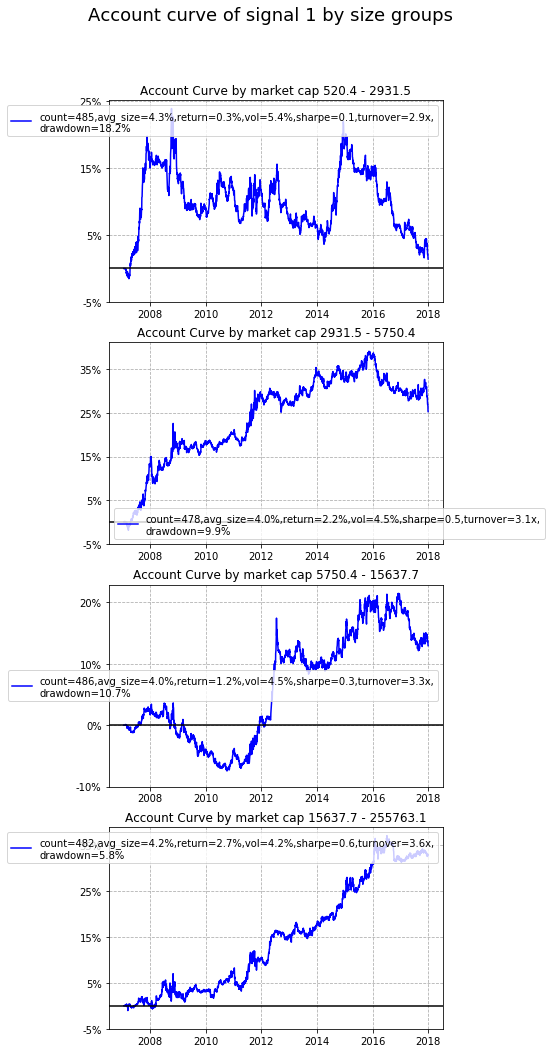

In [320]:
plot_account_curve_by_size([0,0.25,0.5,0.75,1],(6,26),18,
                            "Account curve of signal 1 by size groups",-signal1_rel_df_date_short_Europe,
                            50,30,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["Market cap"],0.1)

### 7.4 - Short signal performance by PE

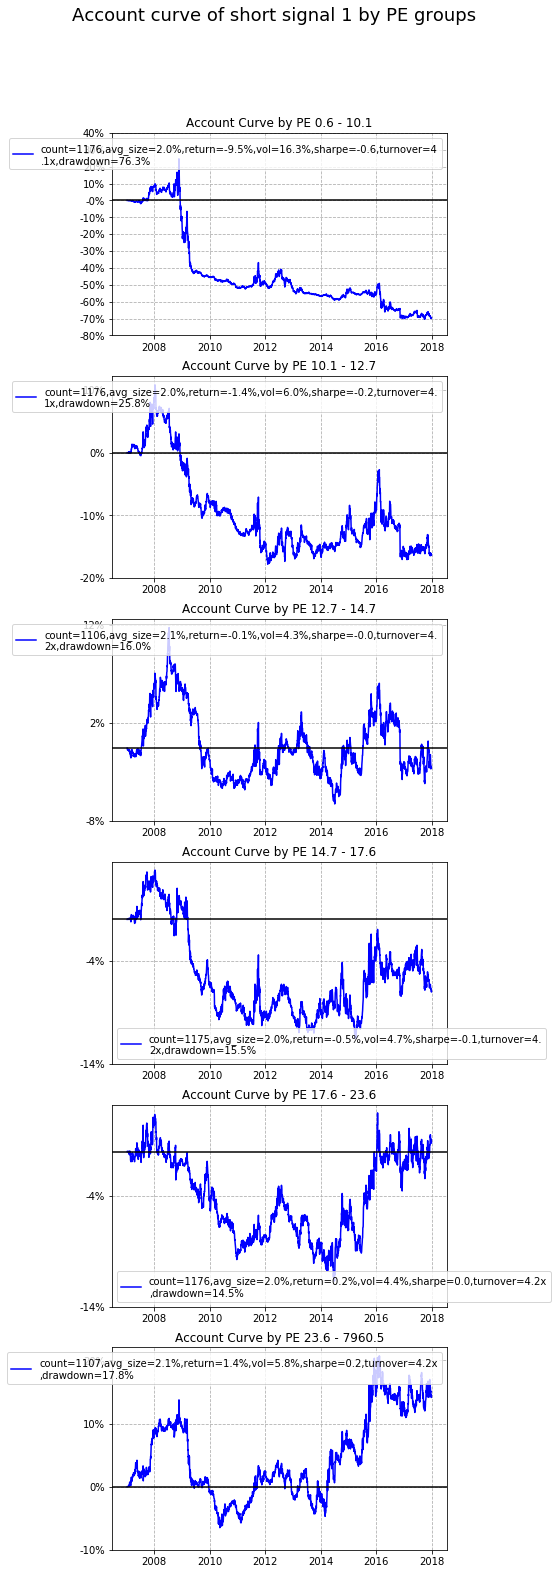

In [276]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of short signal 1 by PE groups",-signal1_rel_df_date_short_US,
                            50,20,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["PE"],0.1)

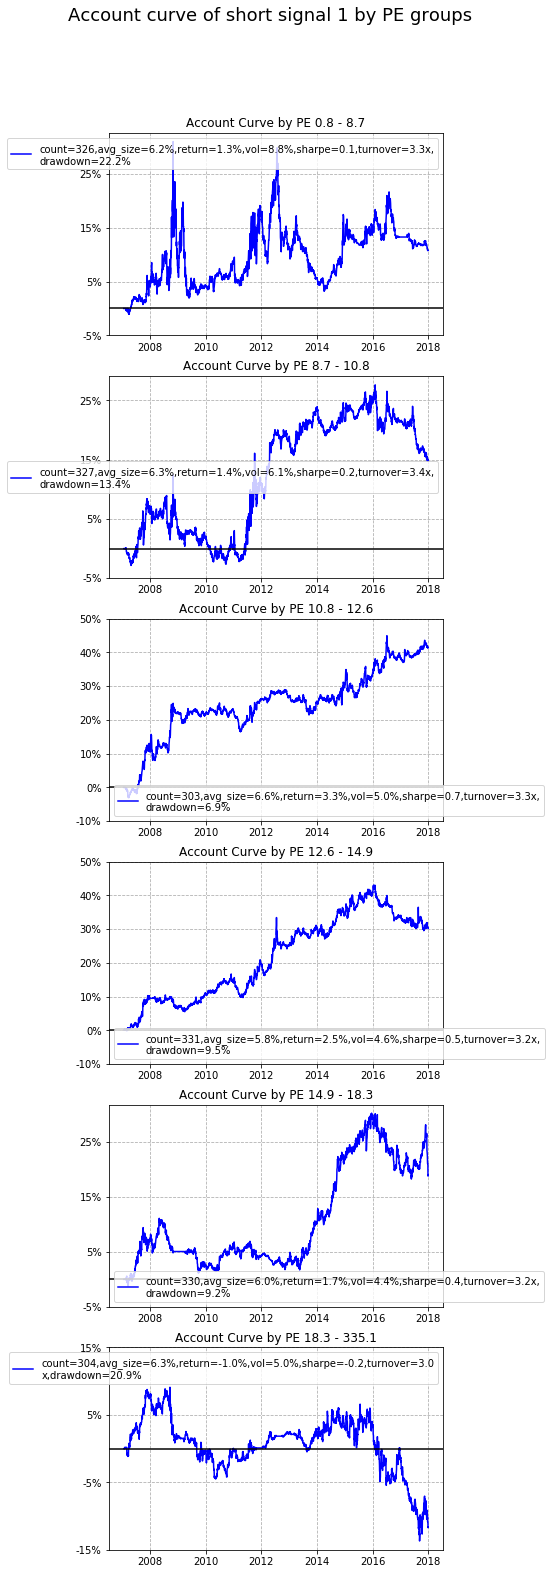

In [321]:
plot_account_curve_by_PE([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of short signal 1 by PE groups",-signal1_rel_df_date_short_Europe,
                            50,20,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["PE"],0.1)

### 7.5 - Short signal performance by PE premium

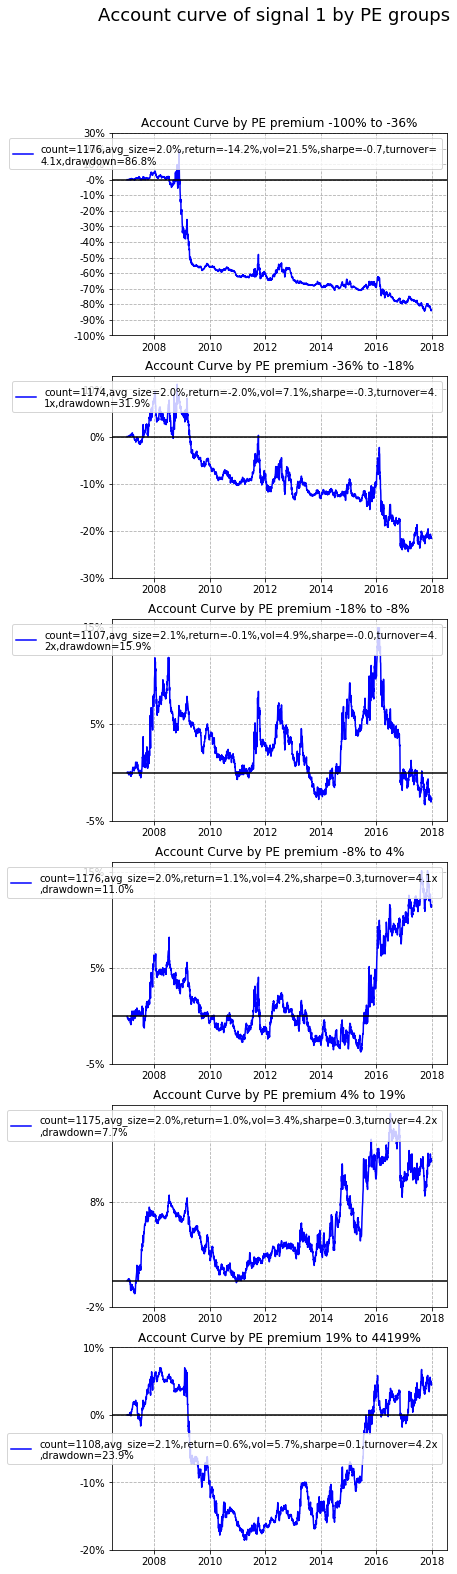

In [280]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",-signal1_rel_df_date_short_US,
                            50,20,data_dict_US["Volume"],data_dict_US["Date"],data_dict_US["PE premium"],0.1)

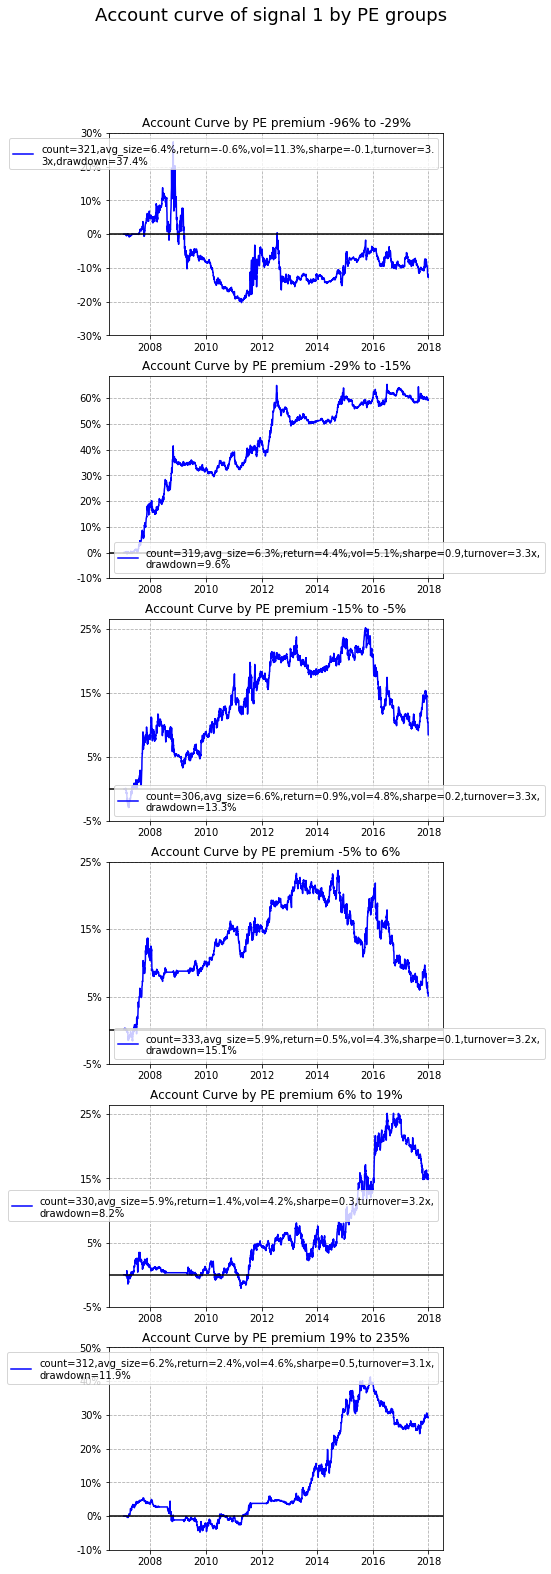

In [323]:
plot_account_curve_by_PE_premium([0,0.17,0.34,0.5,0.67,0.84,1],(6,35),18,
                            "Account curve of signal 1 by PE groups",-signal1_rel_df_date_short_Europe,
                            50,20,data_dict_Europe["Volume"],data_dict_Europe["Date"],data_dict_Europe["PE premium"],0.1)

### 7.6 - Short signal performance by sectors

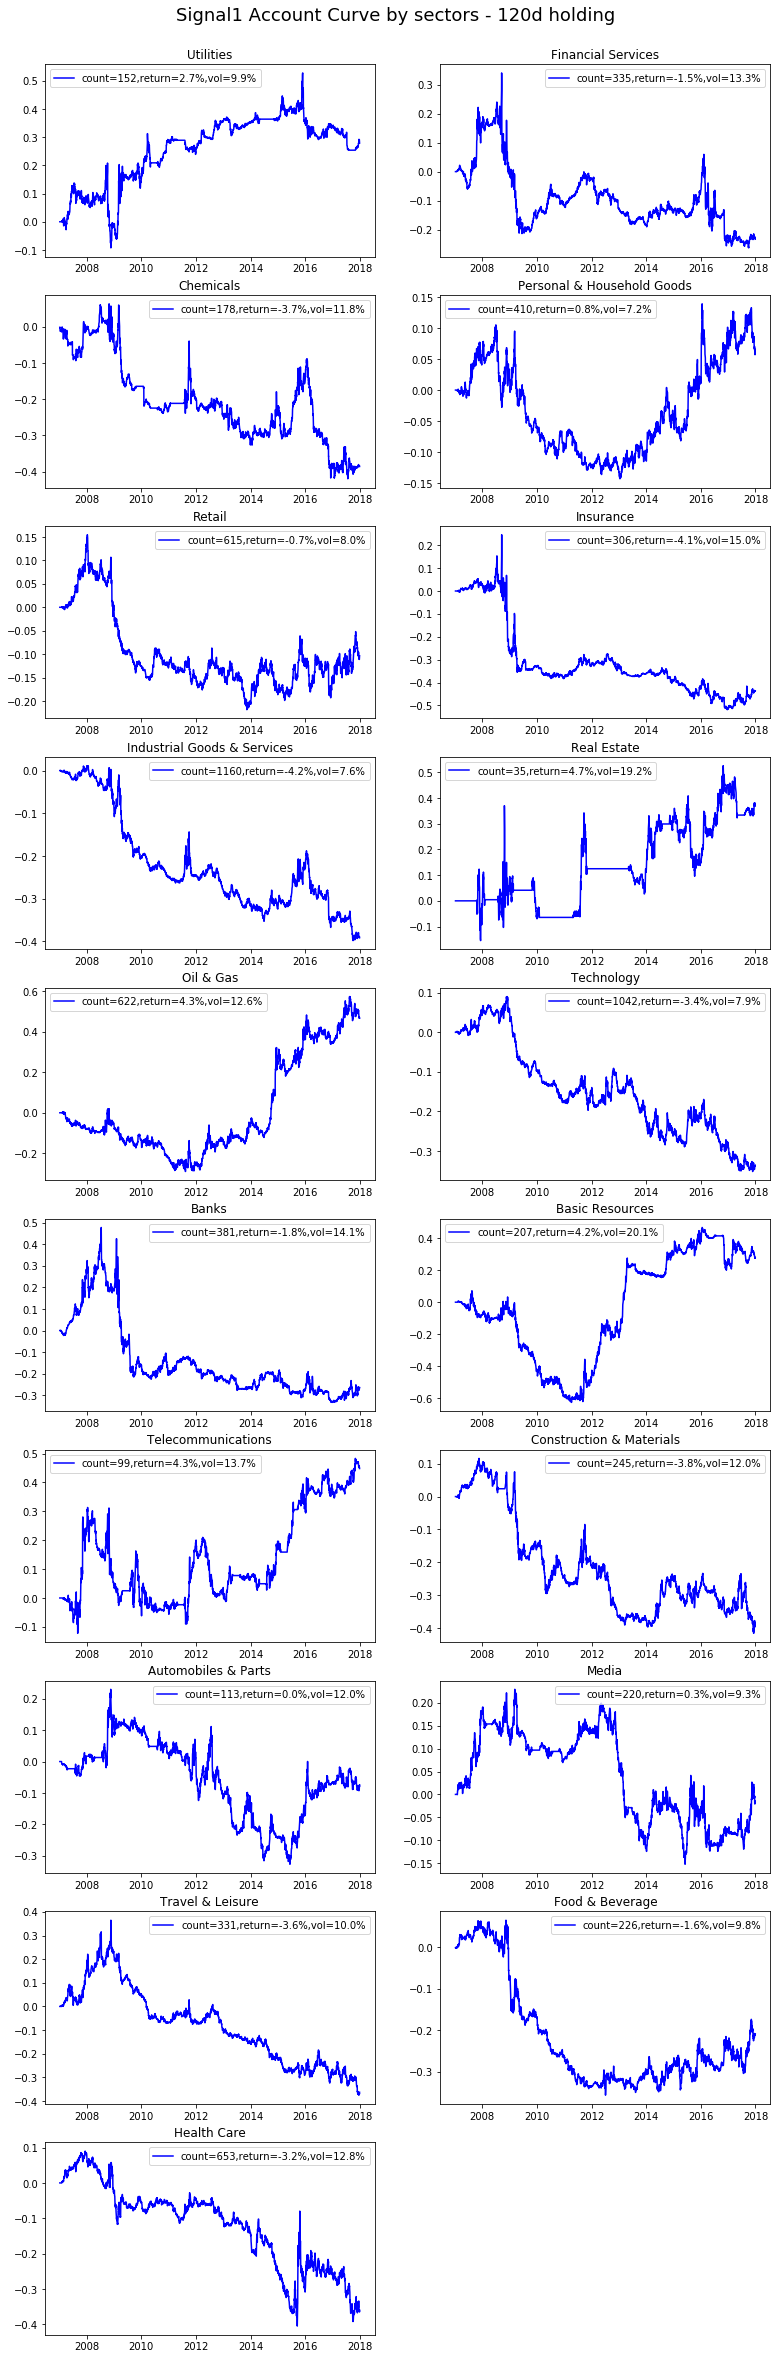

In [283]:
plot_account_curve_by_sector(data_dict_US["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",-signal1_rel_df_date_short_US,
                            50,5,data_dict_US["Volume"],data_dict_US["Date"],0.1)

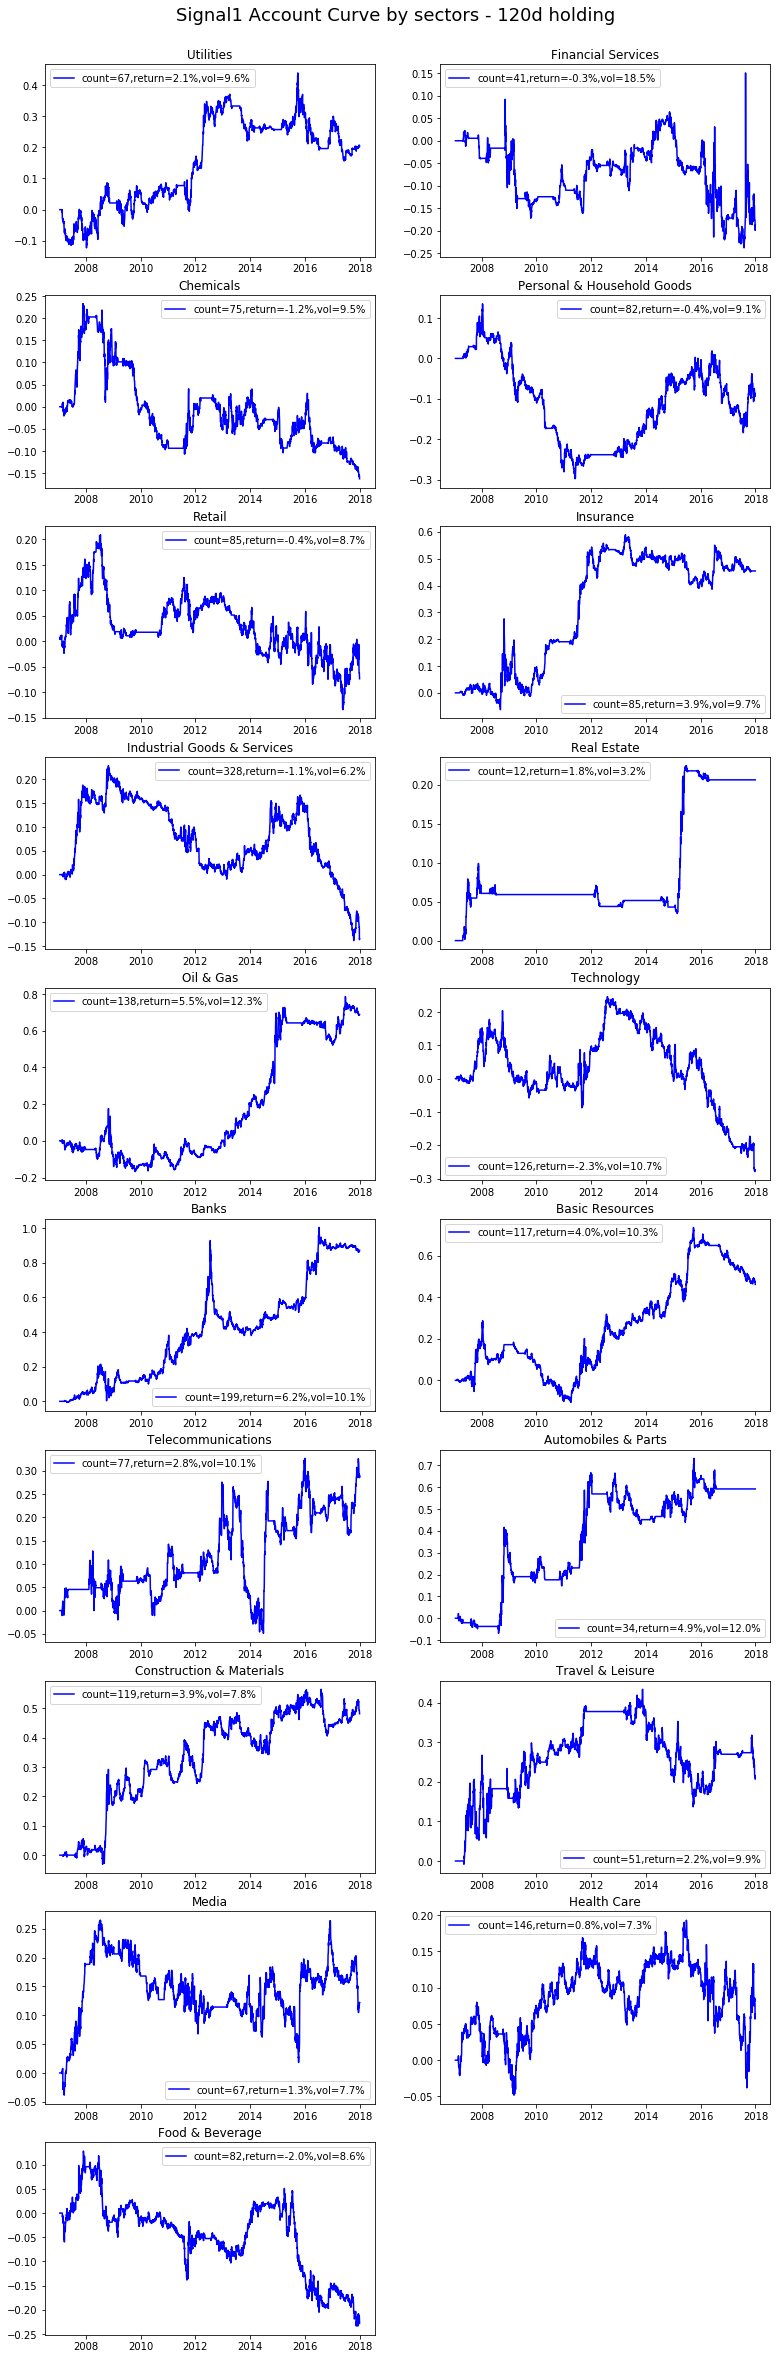

In [324]:
plot_account_curve_by_sector(data_dict_Europe["Property"]["Sector"],(13,80),18,
                            "Signal1 Account Curve by sectors - 120d holding",-signal1_rel_df_date_short_Europe,
                            50,5,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1)

### 7.7 - Short signal performance with stop loss

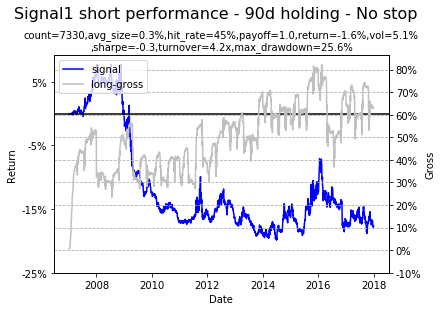

In [307]:
plot_account_curve(signal1_account(-signal1_rel_df_date_short_US,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - No stop",[6,4])

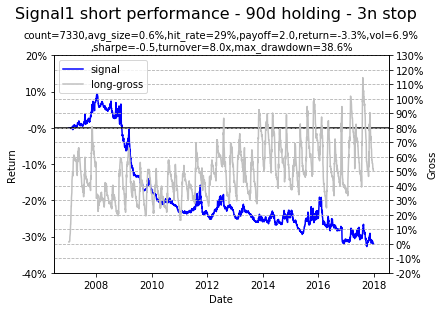

In [308]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_US,3,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - 3n stop",[6,4])

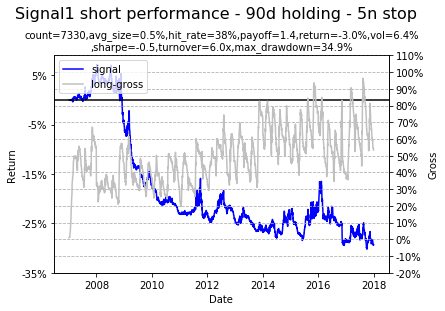

In [309]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_US,5,rel_return_US,30)
                                   ,50,100,data_dict_US["Volume"],data_dict_US["Date"],0.1),
                   "Date","Signal1 short performance - 90d holding - 5n stop",[6,4])

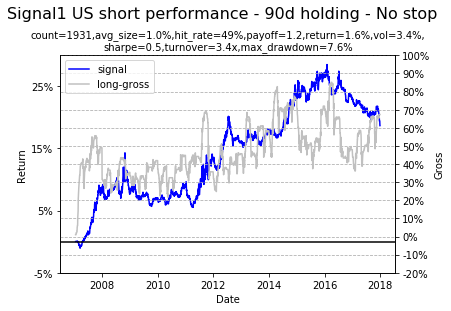

In [341]:
plot_account_curve(signal1_account(-signal1_rel_df_date_short_Europe,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 US short performance - 90d holding - No stop",[6,4])

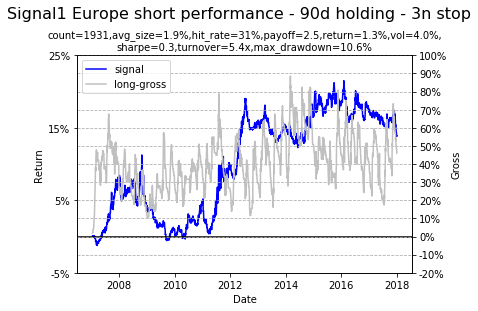

In [327]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,3,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 3n stop",[6,4])

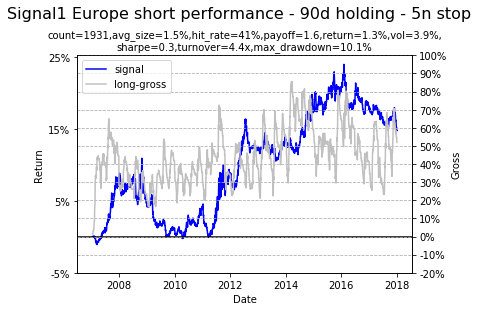

In [328]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,5,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 5n stop",[6,4])

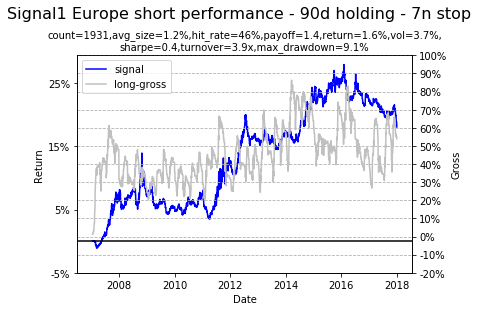

In [329]:
plot_account_curve(signal1_account(signal1_filter_stop(-signal1_rel_df_date_short_Europe,7,rel_return_Europe,30)
                                   ,50,100,data_dict_Europe["Volume"],data_dict_Europe["Date"],0.1),
                   "Date","Signal1 Europe short performance - 90d holding - 7n stop",[6,4])

### 7.8 - Performance for the following quarters - short version

In [631]:
signal1_short_follow_US=signal1_follow(signal1_short_US,data_dict_US["Date"],10)
signal1_short_follow=signal1_follow(signal1_short_Europe,data_dict_Europe["Date"],10)

In [632]:
follow_short_US=signal1_follow_EAR(signal1_short_follow_US,abs_return_US,2,30)
follow_short_Europe=signal1_follow_EAR(signal1_short_follow,abs_return_Europe,2,30)

In [633]:
follow_short_US=follow_short_US.sort_values(by='Quarter+0',axis=1)
follow_short_Europe=follow_short_Europe.sort_values(by='Quarter+0',axis=1)

## 8 - Portfolio construction

### 8.1 - Long signals short market 

In [ ]:
# singal1 dataframe by actual date Europe
signal1_rel_df_date_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,60,False,False,1)

In [ ]:
# singal1 dataframe by actual date US
signal1_rel_df_date_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_US,2,1000,data_dict_US['Revision'],0.05,1000,60,False,False,1)

In [ ]:
# concatnate two dataframes to a global version
signal1_rel_df_date_global=pd.concat([signal1_rel_df_date_Europe,signal1_rel_df_date_US],axis=1)

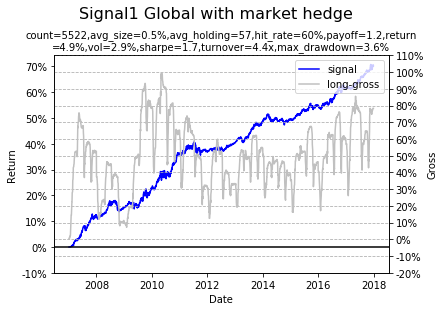

In [803]:
# zero net all the time
signal1_account_global_market=signal1_account(signal1_rel_df_date_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)
signal1_account_global_market[0].name="Signal - market"
plot_account_curve(signal1_account_global_market,
                   "Date","Signal1 Global with market hedge",[6,4])

In [804]:
# correlation with market
correlation_market_df=pd.concat([signal1_account_global_market[0],
                          (1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1,
                          (1+abs_return_Europe.loc["SPX Index"]).cumprod()-1,
                         (1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1,
                         (1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1],axis=1)

In [805]:
correlation_market_df.corr()

Signal - market  SXXP Index  SPX Index  GSRPEMEL Index  \
Signal - market         1.000000    0.407804   0.810890        0.654572   
SXXP Index              0.407804    1.000000   0.835293        0.946136   
SPX Index               0.810890    0.835293   1.000000        0.959373   
GSRPEMEL Index          0.654572    0.946136   0.959373        1.000000   
GSRPEMUL Index          0.784780    0.853733   0.993442        0.969108   

                 GSRPEMUL Index  
Signal - market        0.784780  
SXXP Index             0.853733  
SPX Index              0.993442  
GSRPEMEL Index         0.969108  
GSRPEMUL Index         1.000000

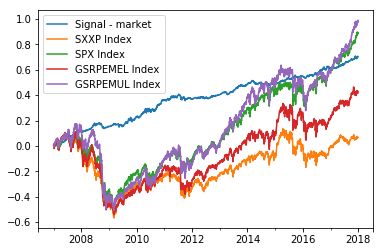

In [806]:
correlation_market_df.plot()

### 8.2 - Long signals short momentum 

In [308]:
# get return dfs
rel_price_Europe,abs_return_Europe,rel_return_mom_Europe,rel_return_sector_Europe=get_return(price_Europe,'GSRPEMEL Index',data_dict_Europe["Property"])
rel_price_US,abs_return_US,rel_return_mom_US,rel_return_sector_US=get_return(price_US,'GSRPEMUL Index',data_dict_US["Property"])

In [309]:
#get signal dfs
signal1_rel_df_date_mom_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_mom_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,60,False,False,1)
signal1_rel_df_date_mom_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_mom_US,2,1000,data_dict_US['Revision'],0.05,1000,60,False,False,1)
signal1_rel_df_date_mom_global=pd.concat([signal1_rel_df_date_mom_Europe,signal1_rel_df_date_mom_US],axis=1)

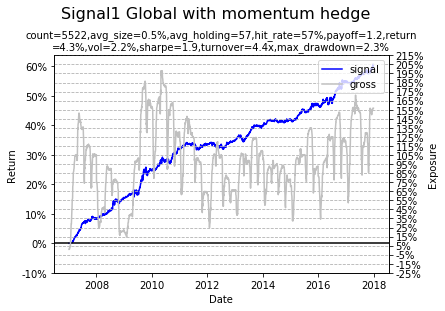

In [310]:
# zero net all the time
signal1_account_global_mom=signal1_account_combine(signal1_abs_df_date_global,None,50,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1,abs_return,0)
signal1_account(signal1_rel_df_date_mom_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)
signal1_account_global_mom[0].name="Signal - momentum"
plot_account_curve(signal1_account_global_mom,
                   "Date","Signal1 Global with momentum hedge",[6,4])

In [809]:
# correlation with market
correlation_mom_df=pd.concat([signal1_account_global_mom[0],
                          (1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1,
                          (1+abs_return_Europe.loc["SPX Index"]).cumprod()-1,
                         (1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1,
                         (1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1],axis=1)

In [810]:
correlation_mom_df.corr()

Signal - momentum  SXXP Index  SPX Index  GSRPEMEL Index  \
Signal - momentum           1.000000    0.353605   0.773890        0.602975   
SXXP Index                  0.353605    1.000000   0.835293        0.946136   
SPX Index                   0.773890    0.835293   1.000000        0.959373   
GSRPEMEL Index              0.602975    0.946136   0.959373        1.000000   
GSRPEMUL Index              0.736467    0.853733   0.993442        0.969108   

                   GSRPEMUL Index  
Signal - momentum        0.736467  
SXXP Index               0.853733  
SPX Index                0.993442  
GSRPEMEL Index           0.969108  
GSRPEMUL Index           1.000000

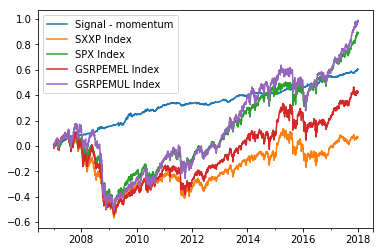

In [811]:
correlation_mom_df.plot()

### 8.3 - Long signals against sector index

In [200]:
#get signal dfs
signal1_rel_df_date_sector_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_sector_Europe,2,1000,data_dict_Europe['Revision'],0.02,1000,60,False,False,1)
signal1_rel_df_date_sector_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_sector_US,2,1000,data_dict_US['Revision'],0.05,1000,60,False,False,1)
signal1_rel_df_date_sector_global=pd.concat([signal1_rel_df_date_sector_Europe,signal1_rel_df_date_sector_US],axis=1)

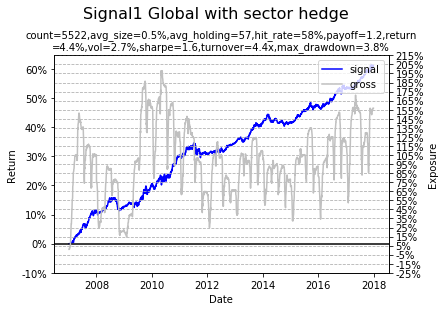

In [201]:
# zero net all the time
signal1_account_global_sector=signal1_account(signal1_rel_df_date_sector_global,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1)
signal1_account_global_sector[0].name="Signal - sector"
plot_account_curve(signal1_account_global_sector,
                   "Date","Signal1 Global with sector hedge",[6,4])

In [814]:
# correlation with market
correlation_sector_df=pd.concat([signal1_account_global_sector[0],
                          (1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1,
                          (1+abs_return_Europe.loc["SPX Index"]).cumprod()-1,
                         (1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1,
                         (1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1],axis=1)

In [815]:
correlation_sector_df.corr()

Signal - sector  SXXP Index  SPX Index  GSRPEMEL Index  \
Signal - sector         1.000000    0.427059   0.824774        0.672129   
SXXP Index              0.427059    1.000000   0.835293        0.946136   
SPX Index               0.824774    0.835293   1.000000        0.959373   
GSRPEMEL Index          0.672129    0.946136   0.959373        1.000000   
GSRPEMUL Index          0.799379    0.853733   0.993442        0.969108   

                 GSRPEMUL Index  
Signal - sector        0.799379  
SXXP Index             0.853733  
SPX Index              0.993442  
GSRPEMEL Index         0.969108  
GSRPEMUL Index         1.000000

### 8.4 - Long short signals

In [222]:
#get signal dfs
signal1_rel_df_date_short_Europe=signal1_df_date(data_dict_Europe['Date'],rel_return_Europe,rel_return_sector_Europe,-1000,-2,data_dict_Europe['Revision'],-1000,-0.02,60,False,False,1)
signal1_rel_df_date_short_US=signal1_df_date(data_dict_US['Date'],rel_return_US,rel_return_sector_US,-1000,-2,data_dict_US['Revision'],-1000,-0.02,60,False,False,1)
signal1_rel_df_date_short_global=pd.concat([signal1_rel_df_date_short_Europe,signal1_rel_df_date_short_US],axis=1)


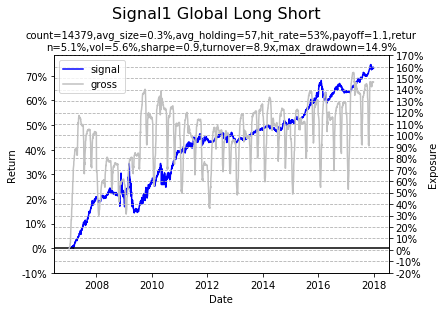

In [271]:
signal1_account_global_LS=signal1_account_combine(signal1_abs_df_date_global,signal1_abs_df_date_short_global,50,50,100,data_dict_global["Volume"],data_dict_global["Date"],0.1,None,0)


signal1_account_global_LS[0].name="Signal - Long Short"
plot_account_curve(signal1_account_global_LS,
                   "Date","Signal1 Global Long Short",[6,4])

In [255]:
# correlation with market
correlation_LS_df=pd.concat([signal1_account_global_LS[0],
                          (1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1,
                          (1+abs_return_Europe.loc["SPX Index"]).cumprod()-1,
                         (1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1,
                         (1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1],axis=1)

In [256]:
correlation_LS_df.corr()

Signal - Long Short  SXXP Index  SPX Index  \
Signal - Long Short             1.000000    0.431518   0.833021   
SXXP Index                      0.431518    1.000000   0.835293   
SPX Index                       0.833021    0.835293   1.000000   
GSRPEMEL Index                  0.683436    0.946136   0.959373   
GSRPEMUL Index                  0.808885    0.853733   0.993442   

                     GSRPEMEL Index  GSRPEMUL Index  
Signal - Long Short        0.683436        0.808885  
SXXP Index                 0.946136        0.853733  
SPX Index                  0.959373        0.993442  
GSRPEMEL Index             1.000000        0.969108  
GSRPEMUL Index             0.969108        1.000000

### 8.5 - Only allow large cap

In [226]:
size_row_date=signal1_abs_df_date_short_global.apply(lambda x: get_market_cap(x.name[0],x.name[1],data_dict_global["Market cap"],data_dict_global["Date"]),axis=0)
quantile_value=size_row_date.quantile([0,0.25,0.5,0.75,1]).values.tolist()
signal1_abs_df_date_short_global_large=signal1_abs_df_date_short_global.loc[:,size_row_date>=4000]

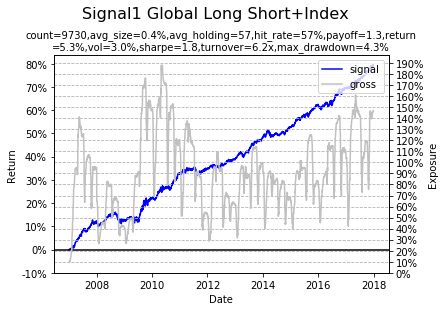

In [302]:
signal1_account_global_LS_large=signal1_account_combine(signal1_abs_df_date_global,signal1_abs_df_date_short_global_large,50,20,100,data_dict_global["Volume"],data_dict_global["Date"],0.1,abs_return_US.loc["GSRPEMUL Index"],10)


signal1_account_global_LS_large[0].name="Signal - LS large cap + Index"
plot_account_curve(signal1_account_global_LS_large,
                   "Date","Signal1 Global Long Short+Index",[6,4])

In [311]:
# correlation with market
correlation_LS_large_df=pd.concat([signal1_account_global_LS_large[0],
                          (1+abs_return_Europe.loc["SXXP Index"]).cumprod()-1,
                          (1+abs_return_Europe.loc["SPX Index"]).cumprod()-1,
                         (1+abs_return_Europe.loc["GSRPEMEL Index"]).cumprod()-1,
                         (1+abs_return_US.loc["GSRPEMUL Index"]).cumprod()-1],axis=1)

In [312]:
correlation_LS_large_df.corr()

Signal - LS large cap + Index  SXXP Index  \
Signal - LS large cap + Index                       1.000000    0.492141   
SXXP Index                                          0.492141    1.000000   
SPX Index                                           0.868582    0.835293   
GSRPEMEL Index                                      0.727827    0.946136   
GSRPEMUL Index                                      0.840341    0.853733   

                               SPX Index  GSRPEMEL Index  GSRPEMUL Index  
Signal - LS large cap + Index   0.868582        0.727827        0.840341  
SXXP Index                      0.835293        0.946136        0.853733  
SPX Index                       1.000000        0.959373        0.993442  
GSRPEMEL Index                  0.959373        1.000000        0.969108  
GSRPEMUL Index                  0.993442        0.969108        1.000000

## 9 - Logistic regression project 

In [68]:
def logit_data_df(date_df,return_df,EAR_period,vol_lookback,revision_df,PE_df,PE_premium_df,AUTOR_lookback_list,MA_lookback_list,price_df,rel_index,holding,entry,y_boundary):
    result_list=[]
    for ticker,row in date_df.iterrows():
        for date in row:
            if type(date)==pd._libs.tslib.Timestamp:
                result_list.append((ticker,date.strftime("%d/%b/%Y")))
            elif type(date)==str:
                result_list.append((ticker,date))
            else:
                pass
    
    logit_data_df=pd.DataFrame(result_list).set_index(0)
    logit_data_df.columns=["Date"]
    logit_data_df.index.name="Ticker"
    
    logit_data_df["EAR"]=logit_data_df.apply(lambda x:EAR_calc(x.name,x["Date"],return_df,EAR_period,vol_lookback),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["Revision"]=logit_data_df.apply(lambda x:get_revision(x.name,x["Date"],revision_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["PE"]=logit_data_df.apply(lambda x:get_PE(x.name,x["Date"],PE_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    logit_data_df["PE premium"]=logit_data_df.apply(lambda x:get_PE_premium(x.name,x["Date"],PE_premium_df,date_df),axis=1)
    logit_data_df=logit_data_df.dropna(axis=0,how='any')

    for i in AUTOR_lookback_list:
        logit_data_df["AUTOR_"+str(i)+'D_score']=logit_data_df.apply(lambda x:AUTOR(x.name,x["Date"],i,price_df,rel_index)[0],axis=1)
        logit_data_df["AUTOR_"+str(i)+'D_slope']=logit_data_df.apply(lambda x:AUTOR(x.name,x["Date"],i,price_df,rel_index)[1],axis=1)    
    
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    for s in MA_lookback_list:
        logit_data_df["MA_"+str(s)+'D_score']=logit_data_df.apply(lambda x:MA(x.name,x["Date"],s,price_df,rel_index)[0],axis=1)
        logit_data_df["MA_"+str(s)+'D_slope']=logit_data_df.apply(lambda x:MA(x.name,x["Date"],s,price_df,rel_index)[1],axis=1)
    
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    logit_data_df["post move"]=logit_data_df.apply(lambda x:get_post_nmove(x.name,x["Date"],return_df,holding,entry),axis=1)>y_boundary
    logit_data_df=logit_data_df.dropna(axis=0,how='any')
    
    return logit_data_df
        

In [69]:
logit_data=logit_data_df(data_dict_US["Date"],rel_return_US,2,30,data_dict_US["Revision"],data_dict_US["PE"],data_dict_US["PE premium"],[100,150,200],[50,100,150,200],price_US,None,50,2,2)

In [70]:
logit_data_Europe=logit_data_df(data_dict_Europe["Date"],rel_return_Europe,2,30,data_dict_Europe["Revision"],data_dict_Europe["PE"],data_dict_Europe["PE premium"],[150],[50,150],price_Europe,None,50,2,2)

In [71]:
def data_normalise(data_df,lower_bound,upper_bound):
    z_score=data_df.iloc[:,1:-1].apply(stats.zscore)
    norm_xy=pd.concat([z_score[(z_score<upper_bound)&(z_score>lower_bound)],data_df.iloc[:,-1]],axis=1).dropna(axis=0,how='any')
    norm_x=norm_xy.iloc[:,:-1]
    norm_y=norm_xy.iloc[:,-1]
    x_orig=norm_x.as_matrix()
    y_orig=(norm_y*1.0).as_matrix().reshape(-1,1)
    return norm_x,norm_y

In [72]:
x_orig,y_orig=data_normalise(logit_data,-5,5)
x_orig_Europe,y_orig_Europe=data_normalise(logit_data_Europe,-5,5)

In [73]:
logit_data

Date        EAR  Revision         PE  PE premium  \
Ticker                                                              
A US      21/Nov/2017  -3.620298 -0.003476  26.922291    0.505338   
A US      16/Aug/2017   5.710477  0.025511  24.153130    0.425354   
A US      23/May/2017   8.374009  0.033556  24.277842    0.502355   
A US      15/Feb/2017   0.457762  0.008830  22.947433    0.490871   
A US      16/Nov/2016   0.657369 -0.018653  20.963823    0.419712   
A US      18/Aug/2016  -2.578968  0.005325  22.355212    0.585307   
A US      17/May/2016   5.373686  0.020303  21.311522    0.577153   
A US      17/Feb/2016  -0.711111 -0.016278  19.098013    0.458817   
A US      17/Nov/2015   5.146209 -0.036623  19.593027    0.546849   
A US      18/Aug/2015   0.009666  0.001327  20.309153    0.661445   
A US      19/May/2015   0.152121  0.003952  23.163841    0.987386   
A US      18/Feb/2015   1.938508 -0.009062  22.984337    1.061178   
A US      18/Nov/2014  -1.269663  0.000000  23.414595    1.179334   
A US      15/Aug/2014   5.439600 -0.012594  12.227105    0.131683   
A US      15/May/2014  -1.082083 -0.003526  12.129837    0.114274   
A US      14/Feb/2014  -8.886835 -0.036579  12.805149    0.186894   
A US      15/Nov/2013   8.411663  0.005680  11.807021    0.117555   
A US      15/Aug/2013   2.588638  0.007970  10.810963    0.033692   
A US      15/May/2013   1.854938 -0.031986  10.553269    0.003506   
A US      15/Feb/2013  -6.005930 -0.042216  10.067895   -0.044389   
A US      20/Nov/2012  -4.213994 -0.086238   8.224788   -0.227036   
A US      16/Aug/2012  -7.887592 -0.063093   8.077708   -0.258327   
A US      15/May/2012   2.619442  0.016181   8.437356   -0.247414   
A US      16/Feb/2012  -1.521764  0.000831   9.544939   -0.163689   
A US      16/Nov/2011   0.203891  0.019268   8.642260   -0.259115   
A US      16/Aug/2011  -1.926282 -0.008617   8.382220   -0.298791   
A US      13/May/2011   4.702581  0.083548  12.465616    0.045522   
A US      15/Feb/2011  -1.944100  0.057268  11.635055   -0.024291   
A US      12/Nov/2010   2.583414  0.030521  10.706740   -0.116692   
A US      17/Aug/2010   5.010245  0.053432   9.086273   -0.269416   
...               ...        ...       ...        ...         ...   
PSD US    05/Nov/2008   3.464611 -0.030280  14.841853    0.002821   
PSD US    05/Aug/2008  -1.916500 -0.012424  16.281283    0.108659   
PTV US    21/Oct/2008   3.053943 -0.005839  12.243649   -0.206586   
PTV US    23/Jul/2008   3.269688 -0.067841  11.860818   -0.229442   
PVAHQ US  06/Nov/2008   0.235830 -0.093318  12.661584   -0.330581   
PVAHQ US  07/Aug/2008   1.341760  0.101100  16.043701   -0.157994   
ROH US    22/Oct/2008   1.888818 -0.047873  19.864837    0.259610   
ROH US    24/Jul/2008   0.195493 -0.020491  18.615700    0.180464   
RX US     23/Oct/2008  -0.746240 -0.035543   7.322057   -0.544233   
RX US     21/Jul/2008  -0.773109 -0.002489  11.653852   -0.295921   
SEPR US   28/Oct/2008   1.406391 -0.022948   9.488886   -0.673660   
SEPR US   29/Jul/2008 -10.527778 -0.232821  12.083877   -0.603089   
SGP US    21/Oct/2008  -0.323855  0.032438   8.185767   -0.833371   
SGP US    22/Jul/2008   0.415674  0.006759  11.802118   -0.766212   
SII US    28/Oct/2008   2.083446 -0.086300   7.620994   -0.601993   
SII US    24/Jul/2008  -0.437162  0.018806  17.608643   -0.104923   
SOV US    14/Oct/2008  -0.406314 -0.466051   6.605832   -0.482697   
SOV US    23/Jul/2008  -0.402521  0.156875  14.096582    0.106540   
SY US     21/Oct/2008   2.333853 -0.002581  12.078020   -0.255386   
SY US     24/Jul/2008   3.754297  0.017607  15.762097   -0.032381   
TRA US    23/Oct/2008   0.921339 -0.257908   3.052353   -0.882098   
TRA US    24/Jul/2008   3.154341  0.228731  10.268264   -0.627819   
WL US     17/Oct/2008  -0.618725 -0.066096  12.860585   -0.121641   
WL US     18/Jul/2008  -3.404015 -0.106232  10.373570   -0.300105   
WYE US    22/Oct/2008   0.375409 -0.000873   8.740441   -0.374238   
WYE US    23/Ju

In [ ]:
x_orig

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_orig,y_orig,test_size=0.25)
x_train_Europe,x_test_Europe,y_train_Europe,y_test_Europe=train_test_split(x_orig_Europe,y_orig_Europe,test_size=0.25)

In [ ]:
x_train

In [564]:
# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    ### START CODE HERE ### (≈ 1 line of code)
    s = 1/(1+np.exp(-z))
    ### END CODE HERE ###
    
    return s

In [593]:
# GRADED FUNCTION: layer_sizes

def layer_sizes(X, Y):
    """
    Arguments:
    X -- input dataset of shape (input size, number of examples)
    Y -- labels of shape (output size, number of examples)
    
    Returns:
    n_x -- the size of the input layer
    n_h -- the size of the hidden layer
    n_y -- the size of the output layer
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    n_x = X.shape[0] # size of input layer
    n_h = 4
    n_y = Y.shape[0] # size of output layer
    ### END CODE HERE ###
    return (n_x, n_h, n_y)

In [594]:
# GRADED FUNCTION: initialize_parameters

def initialize_parameters(n_x, n_h, n_y):
    """
    Argument:
    n_x -- size of the input layer
    n_h -- size of the hidden layer
    n_y -- size of the output layer
    
    Returns:
    params -- python dictionary containing your parameters:
                    W1 -- weight matrix of shape (n_h, n_x)
                    b1 -- bias vector of shape (n_h, 1)
                    W2 -- weight matrix of shape (n_y, n_h)
                    b2 -- bias vector of shape (n_y, 1)
    """
    
    np.random.seed(2) # we set up a seed so that your output matches ours although the initialization is random.
    
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = np.random.randn(n_h, n_x)*0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h)*0.01
    b2 = np.zeros((n_y, 1))
    ### END CODE HERE ###
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [595]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Argument:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters (output of initialization function)
    
    Returns:
    A2 -- The sigmoid output of the second activation
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2"
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Implement Forward Propagation to calculate A2 (probabilities)
    ### START CODE HERE ### (≈ 4 lines of code)
    Z1 = np.dot(W1,X)+b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2,A1)+b2
    A2 = sigmoid(Z2)
    ### END CODE HERE ###
    
    assert(A2.shape == (1, X.shape[1]))
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

In [596]:
# GRADED FUNCTION: compute_cost

def compute_cost(A2, Y, parameters):
    """
    Computes the cross-entropy cost given in equation (13)
    
    Arguments:
    A2 -- The sigmoid output of the second activation, of shape (1, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    parameters -- python dictionary containing your parameters W1, b1, W2 and b2
    
    Returns:
    cost -- cross-entropy cost given equation (13)
    """
    
    m = Y.shape[1] # number of example

    # Compute the cross-entropy cost
    ### START CODE HERE ### (≈ 2 lines of code)
    logprobs = np.multiply(np.log(A2),Y)
    cost = -np.sum(logprobs)
    ### END CODE HERE ###
    
    cost = np.squeeze(cost)     # makes sure cost is the dimension we expect. 
                                # E.g., turns [[17]] into 17 
    assert(isinstance(cost, float))
    
    return cost

In [597]:
# GRADED FUNCTION: backward_propagation

def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    cache -- a dictionary containing "Z1", "A1", "Z2" and "A2".
    X -- input data of shape (2, number of examples)
    Y -- "true" labels vector of shape (1, number of examples)
    
    Returns:
    grads -- python dictionary containing your gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # First, retrieve W1 and W2 from the dictionary "parameters".
    ### START CODE HERE ### (≈ 2 lines of code)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    ### END CODE HERE ###
        
    # Retrieve also A1 and A2 from dictionary "cache".
    ### START CODE HERE ### (≈ 2 lines of code)
    A1 = cache["A1"]
    A2 = cache["A2"]
    ### END CODE HERE ###
    
    # Backward propagation: calculate dW1, db1, dW2, db2. 
    ### START CODE HERE ### (≈ 6 lines of code, corresponding to 6 equations on slide above)
    dZ2 = A2-Y
    dW2 = np.dot(dZ2,A1.T)/m
    db2 = np.sum(dZ2,axis=1,keepdims=True)/m
    dZ1 = np.dot(W2.T,dZ2)*(1 - np.power(A1, 2))
    dW1 = np.dot(dZ1,X.T)/m
    db1 = np.sum(dZ1,axis=1,keepdims=True)/m
    ### END CODE HERE ###
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

In [608]:
# GRADED FUNCTION: update_parameters

def update_parameters(parameters, grads, learning_rate):
    """
    Updates parameters using the gradient descent update rule given above
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients 
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    # Retrieve each parameter from the dictionary "parameters"
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Retrieve each gradient from the dictionary "grads"
    ### START CODE HERE ### (≈ 4 lines of code)
    dW1 = grads["dW1"]
    db1 = grads["db1"]
    dW2 = grads["dW2"]
    db2 = grads["db2"]
    ## END CODE HERE ###
    
    # Update rule for each parameter
    ### START CODE HERE ### (≈ 4 lines of code)
    W1 = W1-learning_rate*dW1
    b1 = b1-learning_rate*db1
    W2 = W2-learning_rate*dW2
    b2 = b2-learning_rate*db2
    ### END CODE HERE ###
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

In [633]:
# GRADED FUNCTION: nn_model

def nn_model(X, Y, n_h,learning_rate,num_iterations = 10000,print_cost=False):
    """
    Arguments:
    X -- dataset of shape (2, number of examples)
    Y -- labels of shape (1, number of examples)
    n_h -- size of the hidden layer
    num_iterations -- Number of iterations in gradient descent loop
    print_cost -- if True, print the cost every 1000 iterations
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]
    
    # Initialize parameters, then retrieve W1, b1, W2, b2. Inputs: "n_x, n_h, n_y". Outputs = "W1, b1, W2, b2, parameters".
    ### START CODE HERE ### (≈ 5 lines of code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    ### END CODE HERE ###
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):
         
        ### START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation. Inputs: "X, parameters". Outputs: "A2, cache".
        A2, cache = forward_propagation(X,parameters)
        
        # Cost function. Inputs: "A2, Y, parameters". Outputs: "cost".
        cost = compute_cost(A2,Y,parameters)
 
        # Backpropagation. Inputs: "parameters, cache, X, Y". Outputs: "grads".
        grads = backward_propagation(parameters,cache,X,Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters,grads,learning_rate)
        
        ### END CODE HERE ###
        
        # Print the cost every 1000 iterations
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

In [634]:
# GRADED FUNCTION: predict

def predict(parameters, X):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
    ### START CODE HERE ### (≈ 2 lines of code)
    A2, cache = forward_propagation(X,parameters)
    predictions = A2>0.5
    ### END CODE HERE ###
    
    return predictions

In [640]:
parameters = nn_model(x_train.T, y_train.T, n_h = 10, learning_rate=0.001, num_iterations = 3000,print_cost=True)

Cost after iteration 0: 7760.487485
Cost after iteration 1000: 8449.308737
Cost after iteration 2000: 9013.795752


In [641]:
predictions = predict(parameters, x_test.T)
print ('Accuracy: %d' % float((np.dot(y_test.T,predictions.T) + np.dot(1-y_test.T,1-predictions.T))/float(y_test.T.size)*100) + '%')

Accuracy: 63%


In [565]:
# GRADED FUNCTION: initialize_with_zeros

def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    w = np.zeros((dim,1))
    b = 0
    ### END CODE HERE ###

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w, b

In [566]:
# GRADED FUNCTION: propagate

def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    ### START CODE HERE ### (≈ 2 lines of code)
    A = sigmoid(np.dot(w.T,X)+b)                                    # compute activation
    cost =(Y*np.log(A)+(1-Y)*np.log(1-A)).sum()/-m                                 # compute cost
    ### END CODE HERE ###
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    ### START CODE HERE ### (≈ 2 lines of code)
    dw = np.dot(X,(A-Y).T)/m
    db = (A-Y).sum()/m
    ### END CODE HERE ###

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [567]:
# GRADED FUNCTION: optimize

def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation (≈ 1-4 lines of code)
        ### START CODE HERE ### 
        grads, cost = propagate(w, b, X, Y)
        ### END CODE HERE ###
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)
        ### START CODE HERE ###
        w = w-learning_rate*dw
        b = b-learning_rate*db
        ### END CODE HERE ###
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [568]:
# GRADED FUNCTION: predict

def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    ### START CODE HERE ### (≈ 1 line of code)
    A = sigmoid(np.dot(w.T,X)+b)
    ### END CODE HERE ###
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        ### START CODE HERE ### (≈ 4 lines of code)
        if A[0,i]<=0.5:
            Y_prediction[0,i]=0
        elif A[0,i]>0.5:
            Y_prediction[0,i]=1
        else:
            pass
        ### END CODE HERE ###
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [569]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    ### START CODE HERE ###
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    ### END CODE HERE ###

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [578]:
d = model(x_train.T, y_train.T, x_test.T, y_test.T, num_iterations = 4000, learning_rate = 0.0001, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.692963
Cost after iteration 200: 0.692780
Cost after iteration 300: 0.692598
Cost after iteration 400: 0.692417
Cost after iteration 500: 0.692237
Cost after iteration 600: 0.692058
Cost after iteration 700: 0.691880
Cost after iteration 800: 0.691702
Cost after iteration 900: 0.691526
Cost after iteration 1000: 0.691350
Cost after iteration 1100: 0.691175
Cost after iteration 1200: 0.691001
Cost after iteration 1300: 0.690829
Cost after iteration 1400: 0.690657
Cost after iteration 1500: 0.690485
Cost after iteration 1600: 0.690315
Cost after iteration 1700: 0.690146
Cost after iteration 1800: 0.689977
Cost after iteration 1900: 0.689809
Cost after iteration 2000: 0.689642
Cost after iteration 2100: 0.689476
Cost after iteration 2200: 0.689311
Cost after iteration 2300: 0.689147
Cost after iteration 2400: 0.688983
Cost after iteration 2500: 0.688821
Cost after iteration 2600: 0.688659
Cost after iteration 2700: 0.688498
Cost

In [553]:
d_Europe = model(x_train_Europe.T, y_train_Europe.T, x_test_Europe.T, y_test_Europe.T, num_iterations = 2000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.483353
Cost after iteration 200: 0.348008
Cost after iteration 300: 0.255406
Cost after iteration 400: 0.188030
Cost after iteration 500: 0.136265
Cost after iteration 600: 0.094646
Cost after iteration 700: 0.059930
Cost after iteration 800: 0.030098
Cost after iteration 900: 0.003843
Cost after iteration 1000: -0.019711
Cost after iteration 1100: -0.041173
Cost after iteration 1200: -0.060979
Cost after iteration 1300: -0.079446
Cost after iteration 1400: -0.096814
Cost after iteration 1500: -0.113265
Cost after iteration 1600: -0.128939
Cost after iteration 1700: -0.143950
Cost after iteration 1800: -0.158388
Cost after iteration 1900: -0.172325
train accuracy: 89.24501116641352 %
test accuracy: 88.7532897144354 %


In [579]:
d_Europe["Y_prediction_train"].sum()

201.0

learning rate is: 0.01
train accuracy: 63.3707790481255 %
test accuracy: 62.901296111665005 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 63.3707790481255 %
test accuracy: 62.901296111665005 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 63.3707790481255 %
test accuracy: 62.901296111665005 %

-------------------------------------------------------



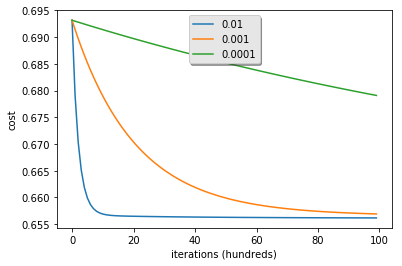

In [337]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(x_train.T, y_train.T, x_test.T, y_test.T, num_iterations = 10000, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()